In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Configurations

n_3b = 2000000
n_all4b = 2000000
seed = 42

In [3]:
import pathlib
import pandas as pd
import numpy as np
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt

from events_data import EventsData


directory = pathlib.Path("../events/MG3")

df_3b = pd.read_hdf(directory / "dataframes" / "threeTag_picoAOD.h5")
print(len(df_3b))
df_3b = df_3b.sample(frac=1, random_state=seed).reset_index(drop=True)
df_3b = df_3b.iloc[:n_3b]

df_bg4b = pd.read_hdf(directory / "dataframes" / "fourTag_10x_picoAOD.h5")
print(len(df_bg4b))
df_bg4b = df_bg4b.sample(frac=1, random_state=seed).reset_index(drop=True)
df_bg4b = df_bg4b.iloc[:n_all4b]

df_signal = pd.read_hdf(directory / "dataframes" / "HH4b_picoAOD.h5")
df_signal = df_signal.sample(frac=1, random_state=seed).reset_index(drop=True)
df_signal = df_signal.iloc[:n_all4b]

df_3b["signal"] = False
df_bg4b["signal"] = False
df_signal["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_signal))


features = [
    "sym_Jet0_pt",
    "sym_Jet1_pt",
    "sym_Jet2_pt",
    "sym_Jet3_pt",
    "sym_Jet0_eta",
    "sym_Jet1_eta",
    "sym_Jet2_eta",
    "sym_Jet3_eta",
    "sym_Jet0_phi",
    "sym_Jet1_phi",
    "sym_Jet2_phi",
    "sym_Jet3_phi",
    "sym_Jet0_m",
    "sym_Jet1_m",
    "sym_Jet2_m",
    "sym_Jet3_m",
]

2013103
2202261
3b-jet events:  2000000
4b-jet events:  2000000
HH4b-jet events:  30856


In [10]:
signal_ratio = 0.01
four_tag_ratio = 0.5
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 50
batch_size = 1024
val_ratio = 0.33
test_ratio = 0.5

In [11]:
pl.seed_everything(seed)
np.random.seed(seed)

events_3b = EventsData.from_dataframe(df_3b, features)
events_3b.shuffle(seed=seed)

events_bg4b = EventsData.from_dataframe(df_bg4b, features)
events_bg4b.shuffle(seed=seed)
events_bg4b.trim(n_all4b - int(n_all4b * signal_ratio))

events_signal = EventsData.from_dataframe(df_signal, features)
events_signal.shuffle(seed=seed)
events_signal.trim(int(n_all4b * signal_ratio))

# set weight ratio to be exactly signal ratio
new_hh4b_weights = (
    (signal_ratio / (1 - signal_ratio))
    * (events_bg4b.total_weight / events_signal.total_weight)
    * events_signal.weights
)
events_signal.reweight(new_hh4b_weights)

# set four tag ratio to be exactly four_tag_ratio

new_3b_weights = (
    (four_tag_ratio / (1 - four_tag_ratio))
    * (
        (events_bg4b.total_weight + events_signal.total_weight)
        / events_3b.total_weight
    )
    * events_3b.weights
)
events_3b.reweight(new_3b_weights)

events_train = EventsData.merge([events_3b, events_bg4b, events_signal])

# reduce number of 4b samples to 1/8
print(
    "4b ratio: ",
    events_train.total_weight_4b / events_train.total_weight,
)
print(
    "Signal ratio: ",
    events_train.total_weight_signal / events_train.total_weight_4b,
)

print(len(events_train))
events_train.shuffle(seed=seed)
events_train, events_test = events_train.split(
    1 - test_ratio, name_1="fvt_train", name_2="fvt_test", seed=seed
)
print(len(events_train))
events_train.shuffle(seed=seed)
events_train, events_val = events_train.split(
    0.67, name_1="fvt_train", name_2="fvt_val", seed=seed
)
print(len(events_train))
print(events_train.total_weight_4b / events_train.total_weight)
print(events_val.total_weight_4b / events_val.total_weight)
print(events_test.total_weight_4b / events_test.total_weight)

events_train.fit_batch_size(batch_size)
events_val.fit_batch_size(batch_size)

Seed set to 42


4b ratio:  0.5000002
Signal ratio:  0.01
4000000
2000000
1340000
0.50015414
0.500444
0.49975026


# Test dataset (Not validation dataset)

In [12]:
print("Test Data")
from fvt_classifier import FvTClassifier

num_classes = 2
dim_input_jet_features = 4
lr = 1e-3
run_name = "_".join(
    [
        "fvt_picoAOD",
        f"signal_ratio={signal_ratio}",
        f"four_tag_ratio={four_tag_ratio}",
        f"dijet={dim_dijet_features}",
        f"quadjet={dim_quadjet_features}",
        f"n_3b={n_3b}",
        f"n_all4b={n_all4b}",
        f"epochs={max_epochs}",
        f"batch_size={batch_size}",
        f"val_ratio={val_ratio}",
        f"test_ratio={test_ratio}",
        f"seed={seed}",
    ]
)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
fvt_model.eval()
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

# events_train.set_model_scores(fvt_model)
# events_val.set_model_scores(fvt_model)
events_test.set_model_scores(fvt_model)

# logits = fvt_model(events_train.X_torch.to(device))
# loss = fvt_model.loss(logits, events_train.is_4b_torch.to(device)).detach().cpu()
# train_loss = ((events_train.weights_torch * loss).sum() / events_train.weights_torch.sum()).numpy()

# logits = fvt_model(events_val.X_torch.to(device))
# loss = fvt_model.loss(logits, events_val.is_4b_torch.to(device)).detach().cpu()
# val_loss = ((events_val.weights_torch * loss).sum() / events_val.weights_torch.sum()).numpy()

# logits = fvt_model(events_test.X_torch.to(device))
# loss = fvt_model.loss(logits, events_test.is_4b_torch.to(device)).detach().cpu()
# test_loss = ((events_test.weights_torch * loss).sum() / events_test.weights_torch.sum()).numpy()

# print("Train loss: ", train_loss)
# print("Val loss: ", val_loss)
# print("Test loss: ", test_loss)

# print("Train weights: ", events_train.total_weight_signal / events_train.total_weight)
# print("Val weights: ", events_val.total_weight_signal / events_val.total_weight)
# print("Test weights: ", events_test.total_weight_signal / events_test.total_weight)

Test Data


**Test Data**


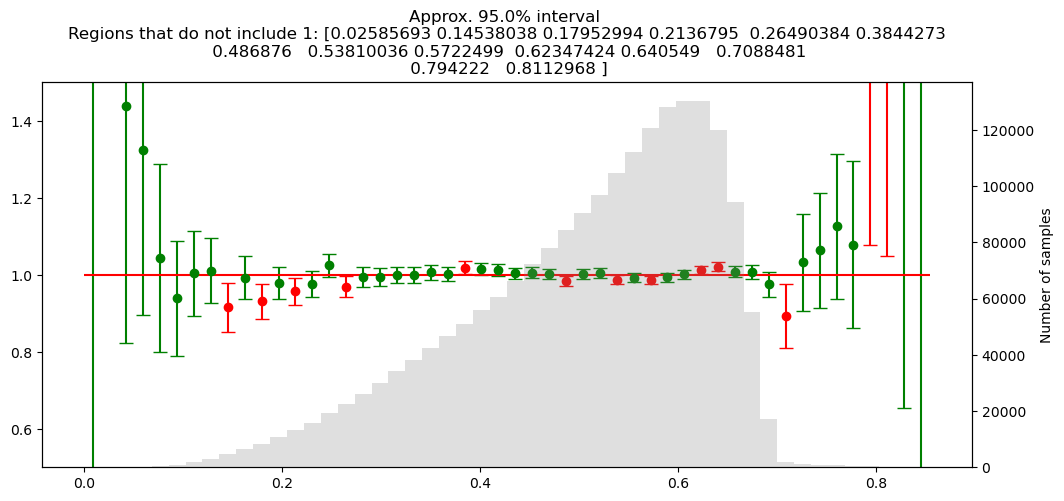

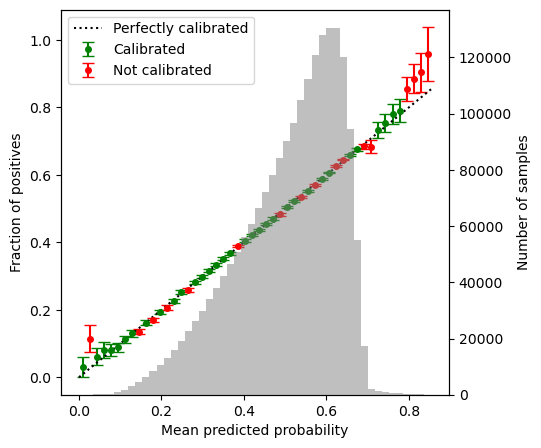

In [13]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

print("**Test Data**")


# plot_prob_weighted_histogram1d(events_train.fvt_score, 
#                                events_train.fvt_score, 
#                                events_train.is_4b,
#                                n_bins=50, 
#                                sample_weights=events_train.weights,
#                                ylim=(0.5, 1.5))
# calibration_plot(events_train.fvt_score, events_train.is_4b,
#                  bins=50,
#                  sample_weights=events_train.weights)

# plot_prob_weighted_histogram1d(events_val.fvt_score, 
#                                events_val.fvt_score, 
#                                events_val.is_4b,
#                                n_bins=50, 
#                                sample_weights=events_val.weights,
#                                ylim=(0.5, 1.5))
# calibration_plot(events_val.fvt_score, events_val.is_4b,
#                  bins=50,
#                  sample_weights=events_val.weights)

plot_prob_weighted_histogram1d(events_test.fvt_score, 
                               events_test.fvt_score, 
                               events_test.is_4b,
                               n_bins=50, 
                               sample_weights=events_test.weights,
                               ylim=(0.5, 1.5))
calibration_plot(events_test.fvt_score, events_test.is_4b,
                 bins=50,
                 sample_weights=events_test.weights)

/tmp/ipykernel_1059299/1964186131.py:19: RuntimeWarning: invalid value encountered in divide
  ratio_signal_fvt_cut = np.cumsum(hist_signal[::-1]) / np.cumsum(hist_bg4b[::-1] + hist_signal[::-1])


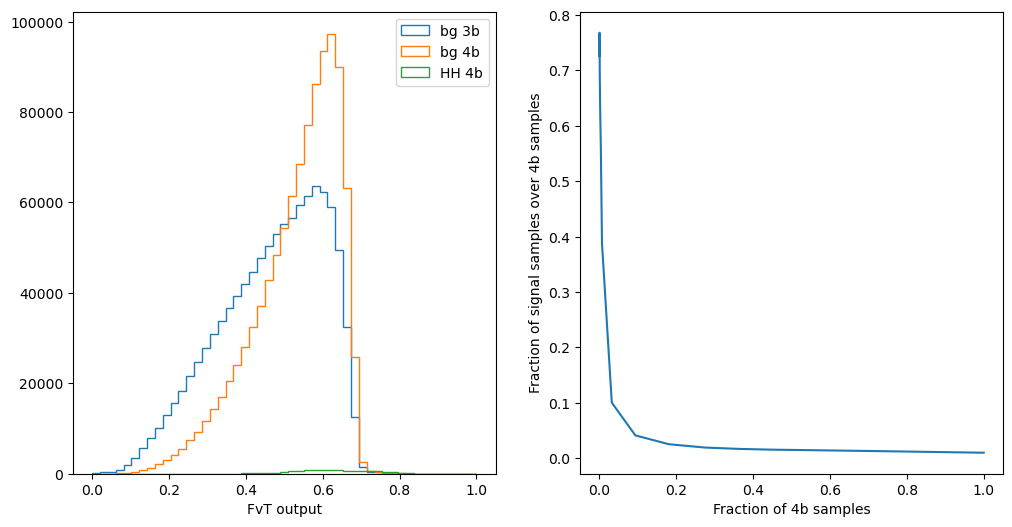

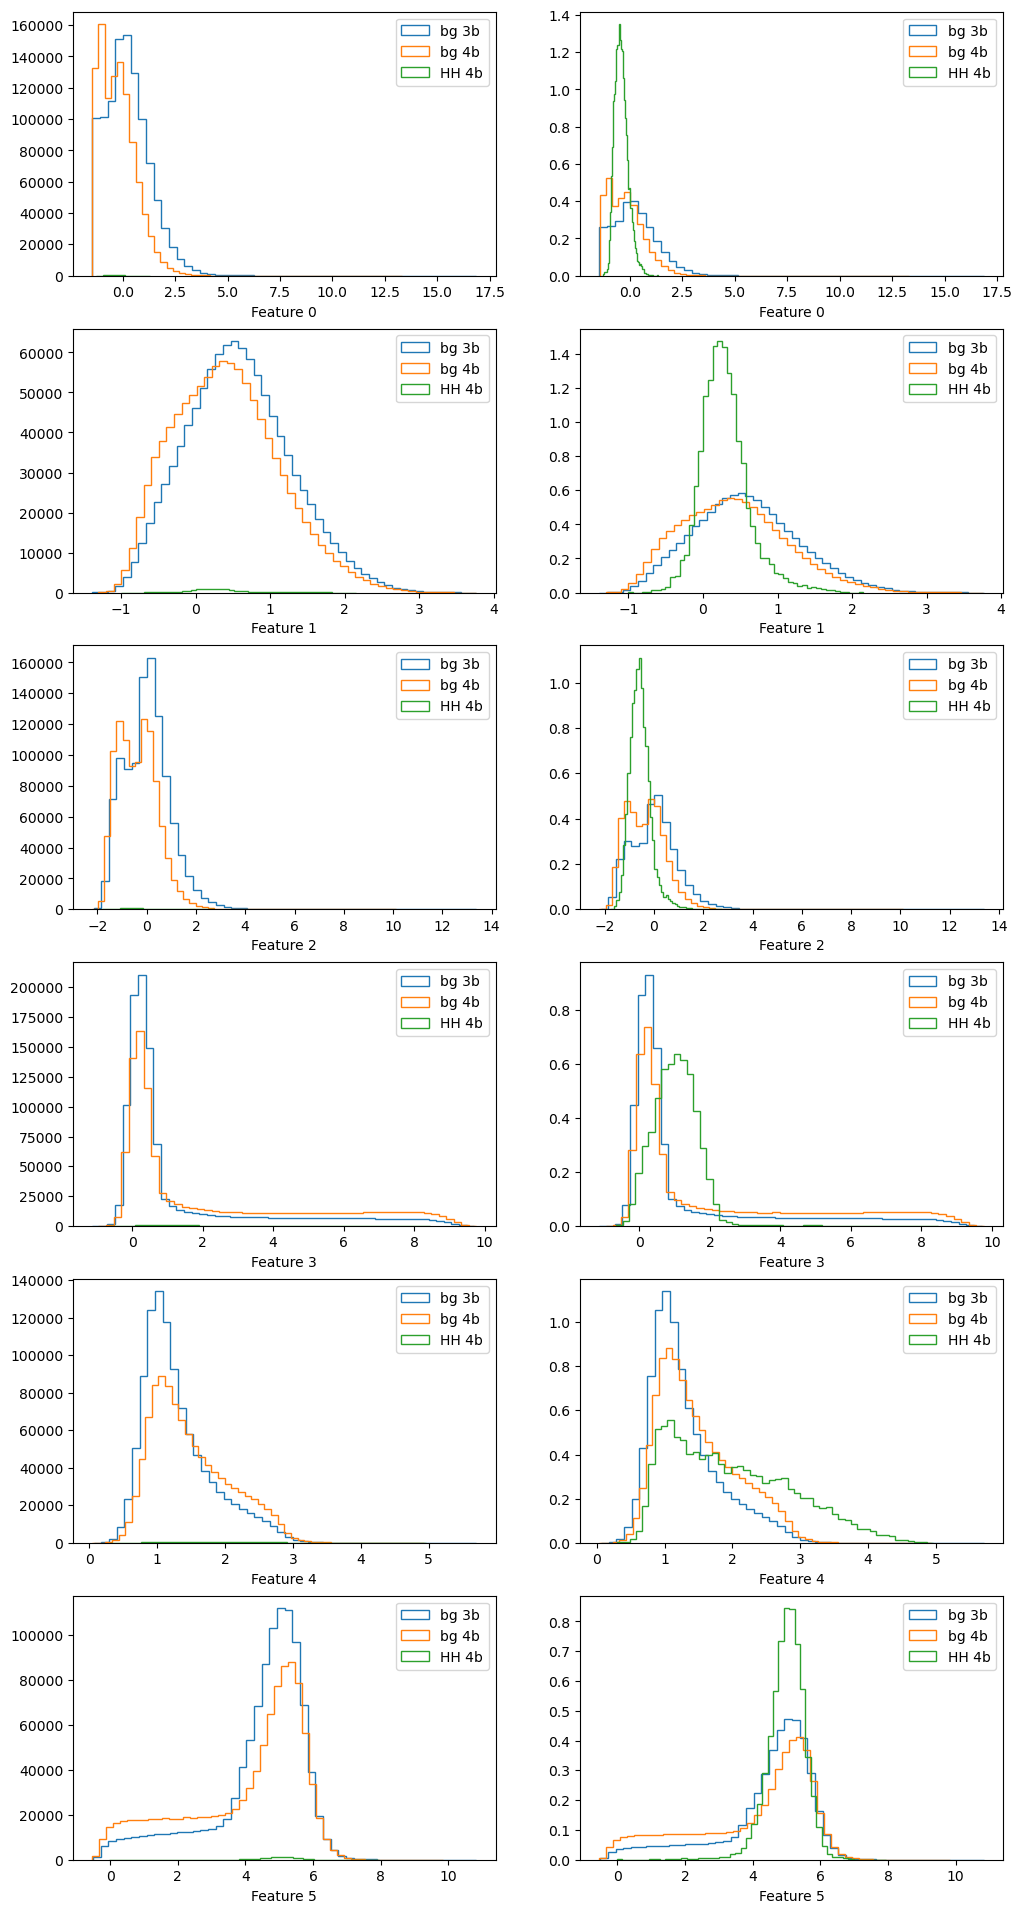

In [14]:
import matplotlib.pyplot as plt

# Pair plots with prob4b threshold

is_3b_test, is_bg4b_test, is_signal_test = events_test.is_3b, events_test.is_bg4b, events_test.is_signal
is_4b_test, w_test = events_test.is_4b, events_test.weights
fvt_score_test = events_test.fvt_score
att_q_repr_test = events_test.att_q_repr

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

bins_range = np.linspace(0, 1, 50)
hist_3b, _, _ = ax[0].hist(fvt_score_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
hist_bg4b, _, _ = ax[0].hist(fvt_score_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
hist_signal, _, _ = ax[0].hist(fvt_score_test[is_signal_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_signal_test])
ax[0].legend()
ax[0].set_xlabel("FvT output")

ratio_signal_fvt_cut = np.cumsum(hist_signal[::-1]) / np.cumsum(hist_bg4b[::-1] + hist_signal[::-1])
ratio_signal_fvt_cut = ratio_signal_fvt_cut[::-1]
ratio_4b_samples_fvt_cut = np.cumsum(hist_bg4b[::-1] + hist_signal[::-1]) / np.sum(hist_bg4b + hist_signal)
ratio_4b_samples_fvt_cut = ratio_4b_samples_fvt_cut[::-1]

ax[1].plot(ratio_4b_samples_fvt_cut, ratio_signal_fvt_cut, label="Signal / all 4b")
ax[1].set_xlabel("Fraction of 4b samples")
ax[1].set_ylabel("Fraction of signal samples over 4b samples")

plt.show()
plt.close()

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 24))

for i in range(dim_quadjet_features):
    ax[i, 0].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
    ax[i, 0].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
    ax[i, 0].hist(att_q_repr_test[is_signal_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_signal_test])
    ax[i, 0].legend()
    ax[i, 0].set_xlabel(f"Feature {i}")
    
    ax[i, 1].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=True, weights=w_test[is_3b_test])
    ax[i, 1].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_bg4b_test])
    ax[i, 1].hist(att_q_repr_test[is_signal_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_signal_test])
    ax[i, 1].legend()
    ax[i, 1].set_xlabel(f"Feature {i}")

plt.show()
plt.close()



Seed set to 42
Seed set to 42
Seed set to 42


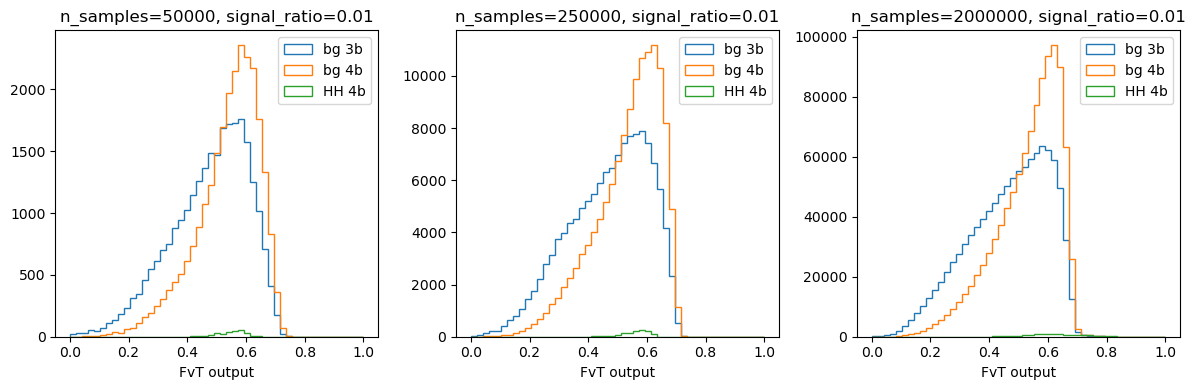

Seed set to 52
Seed set to 52
Seed set to 52


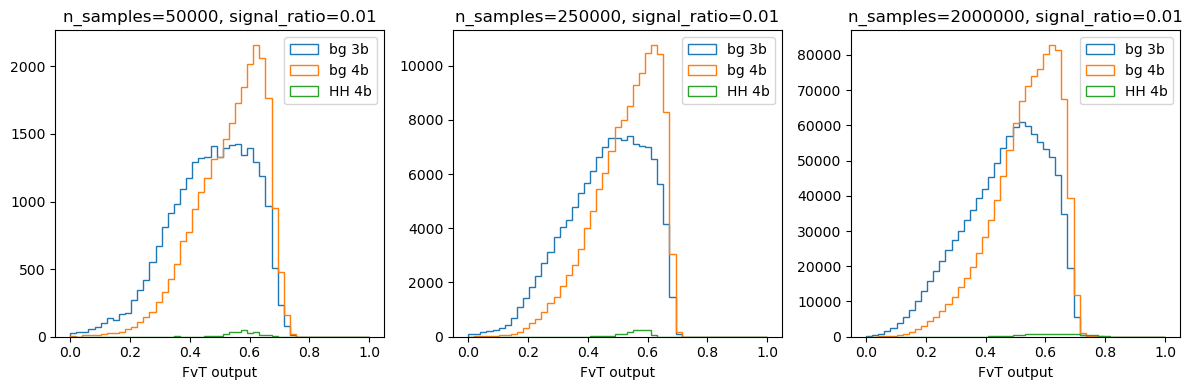

Seed set to 62
Seed set to 62
Seed set to 62


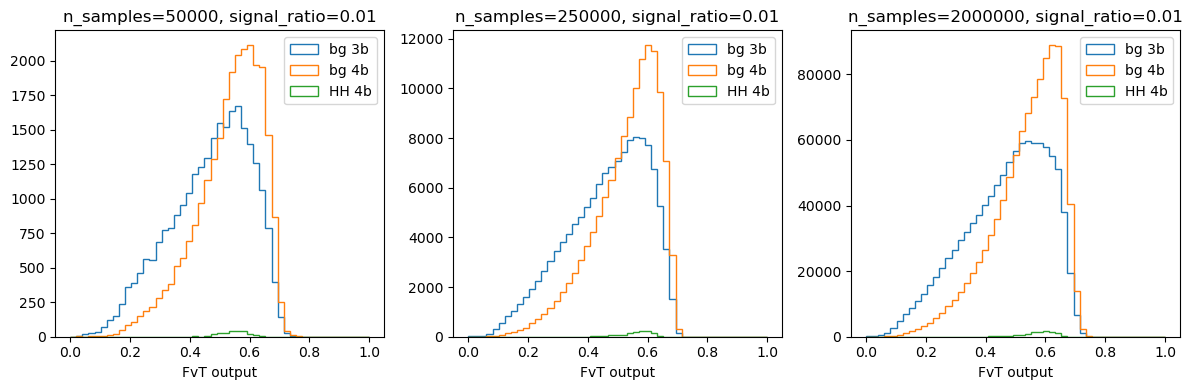

Seed set to 72
Seed set to 72
Seed set to 72


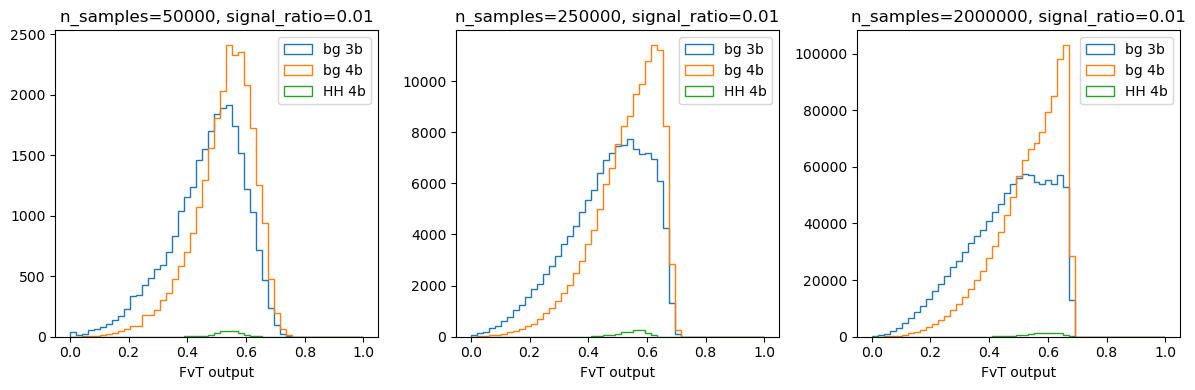

Seed set to 82
Seed set to 82
Seed set to 82


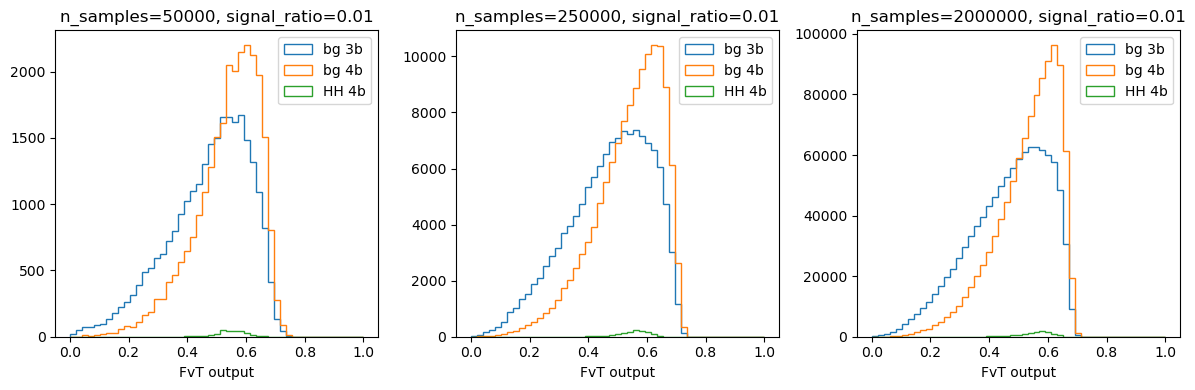

Seed set to 92
Seed set to 92
Seed set to 92


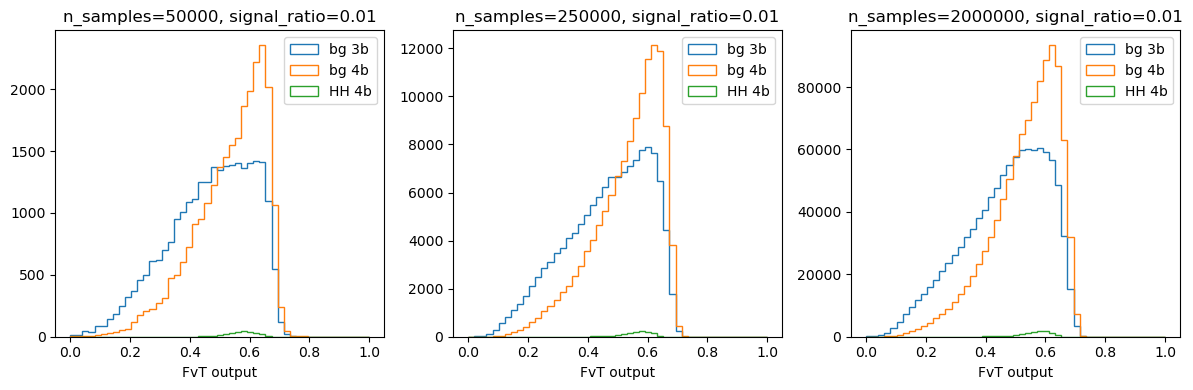

In [15]:
from code_fragments import routine_1, fvt_score_hist, att_q_repr_hist

nrows, ncols = 1, 3

for seed in [42, 52, 62, 72, 82, 92]:
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4))
    for ax_cnt, n_samples in enumerate([50000, 250000, 2000000]):
        for signal_ratio in [0.01]:
            current_ax = ax[ax_cnt]
            current_ax.set_title(f"n_samples={n_samples}, signal_ratio={signal_ratio}")
            events_test = routine_1(signal_ratio, seed, n_3b=n_samples, n_all4b=n_samples, return_keys=["test"])["test"]
            fvt_score_hist(events_test, current_ax)

    plt.tight_layout()
    plt.show()
    plt.close()

seed=42, n_samples=50000


Seed set to 42


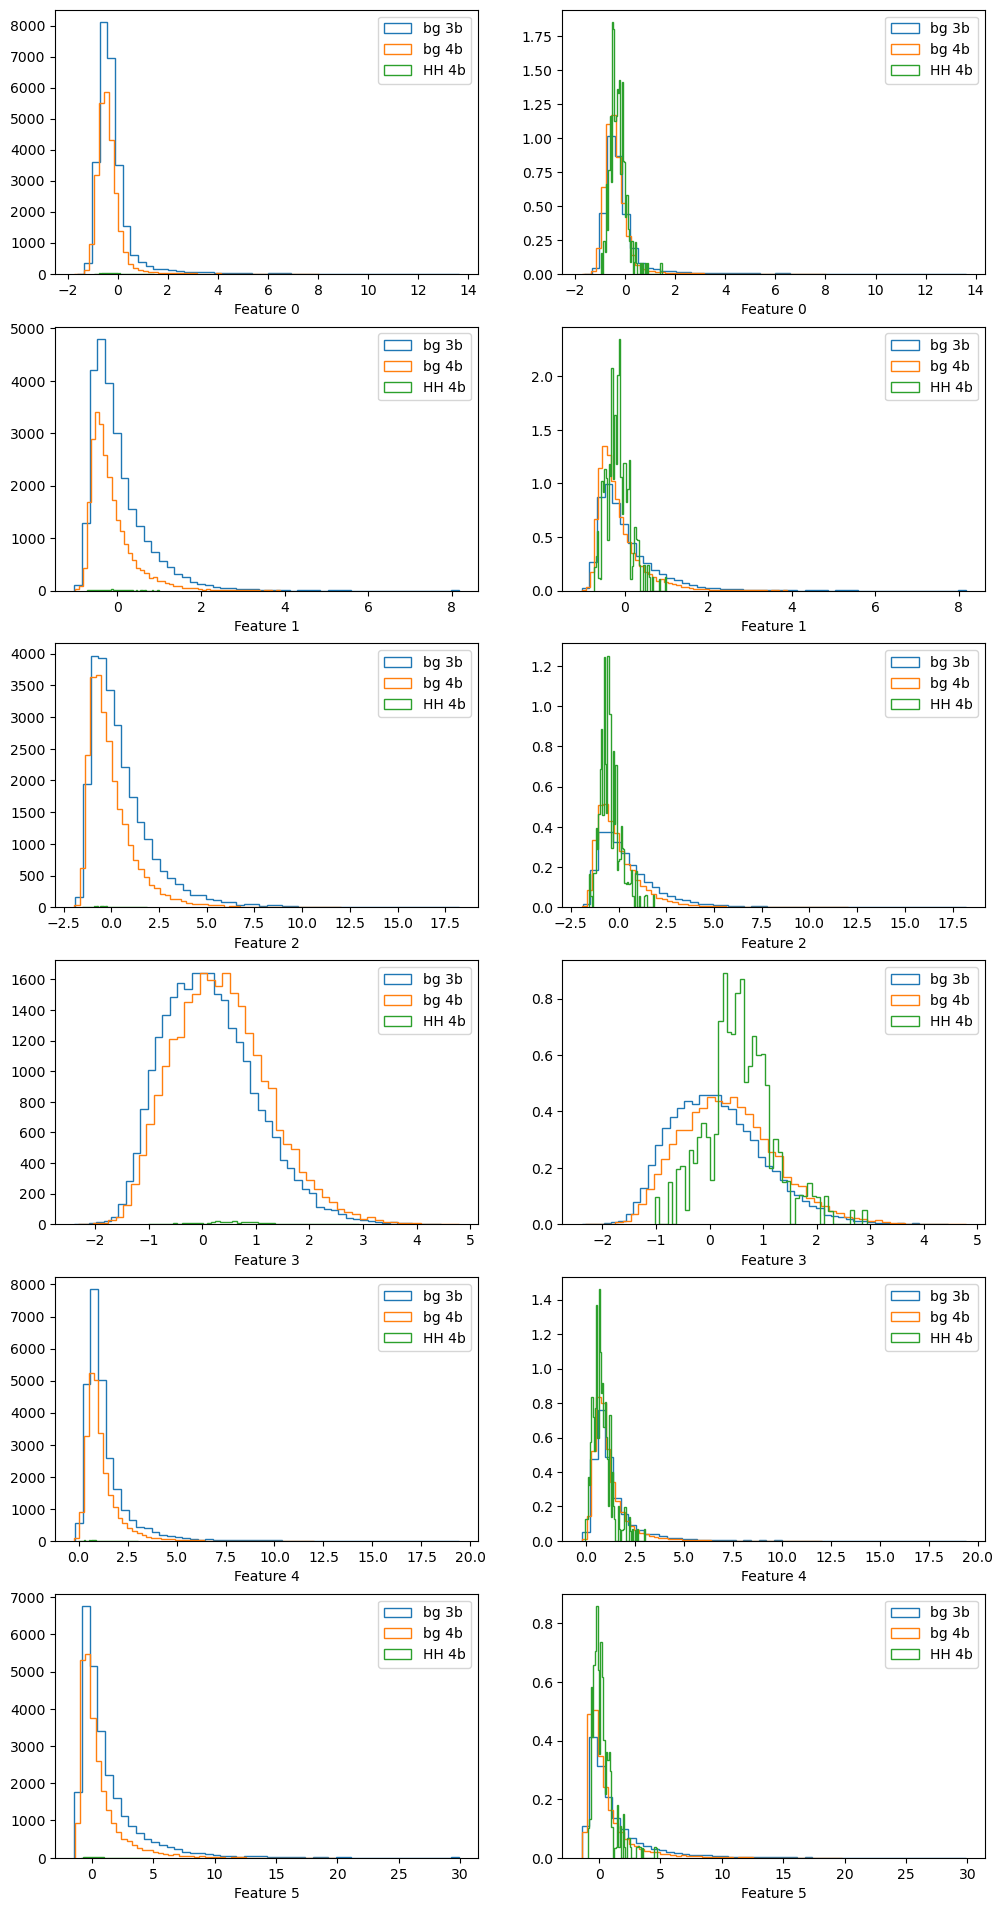

seed=42, n_samples=250000


Seed set to 42


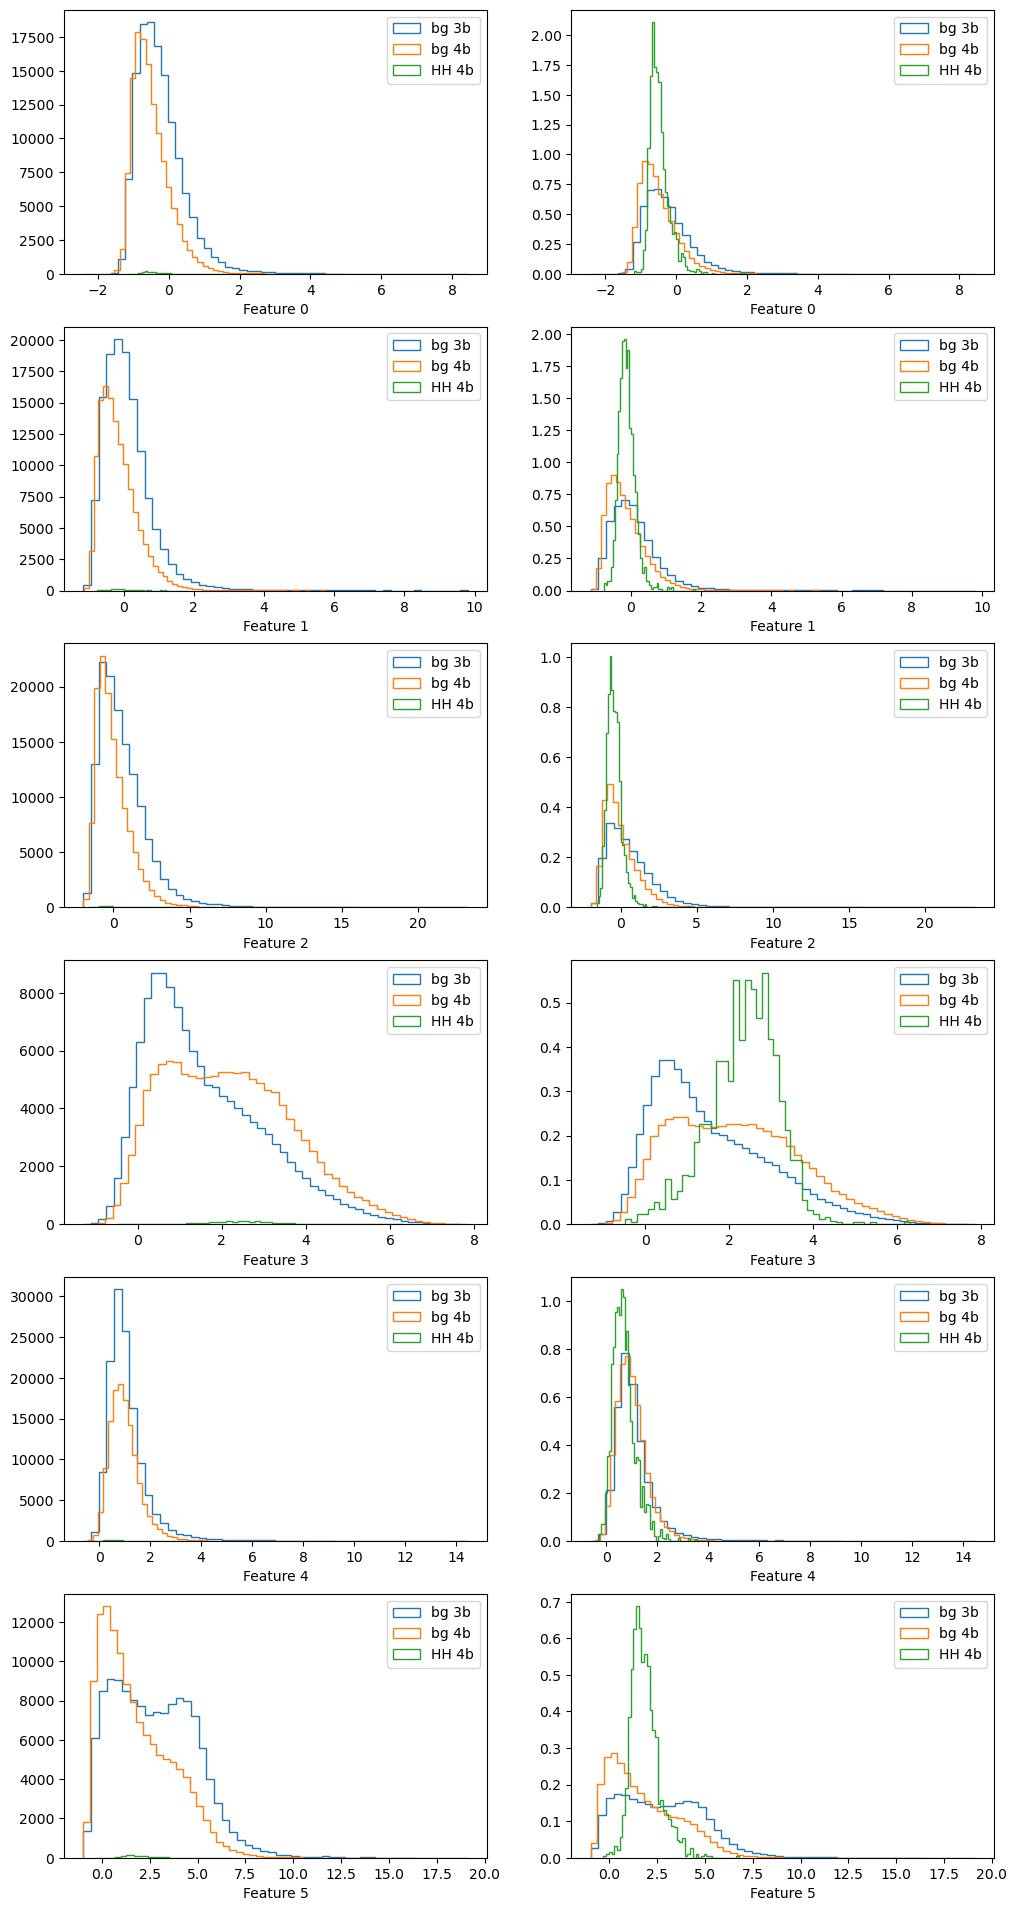

seed=42, n_samples=2000000


Seed set to 42


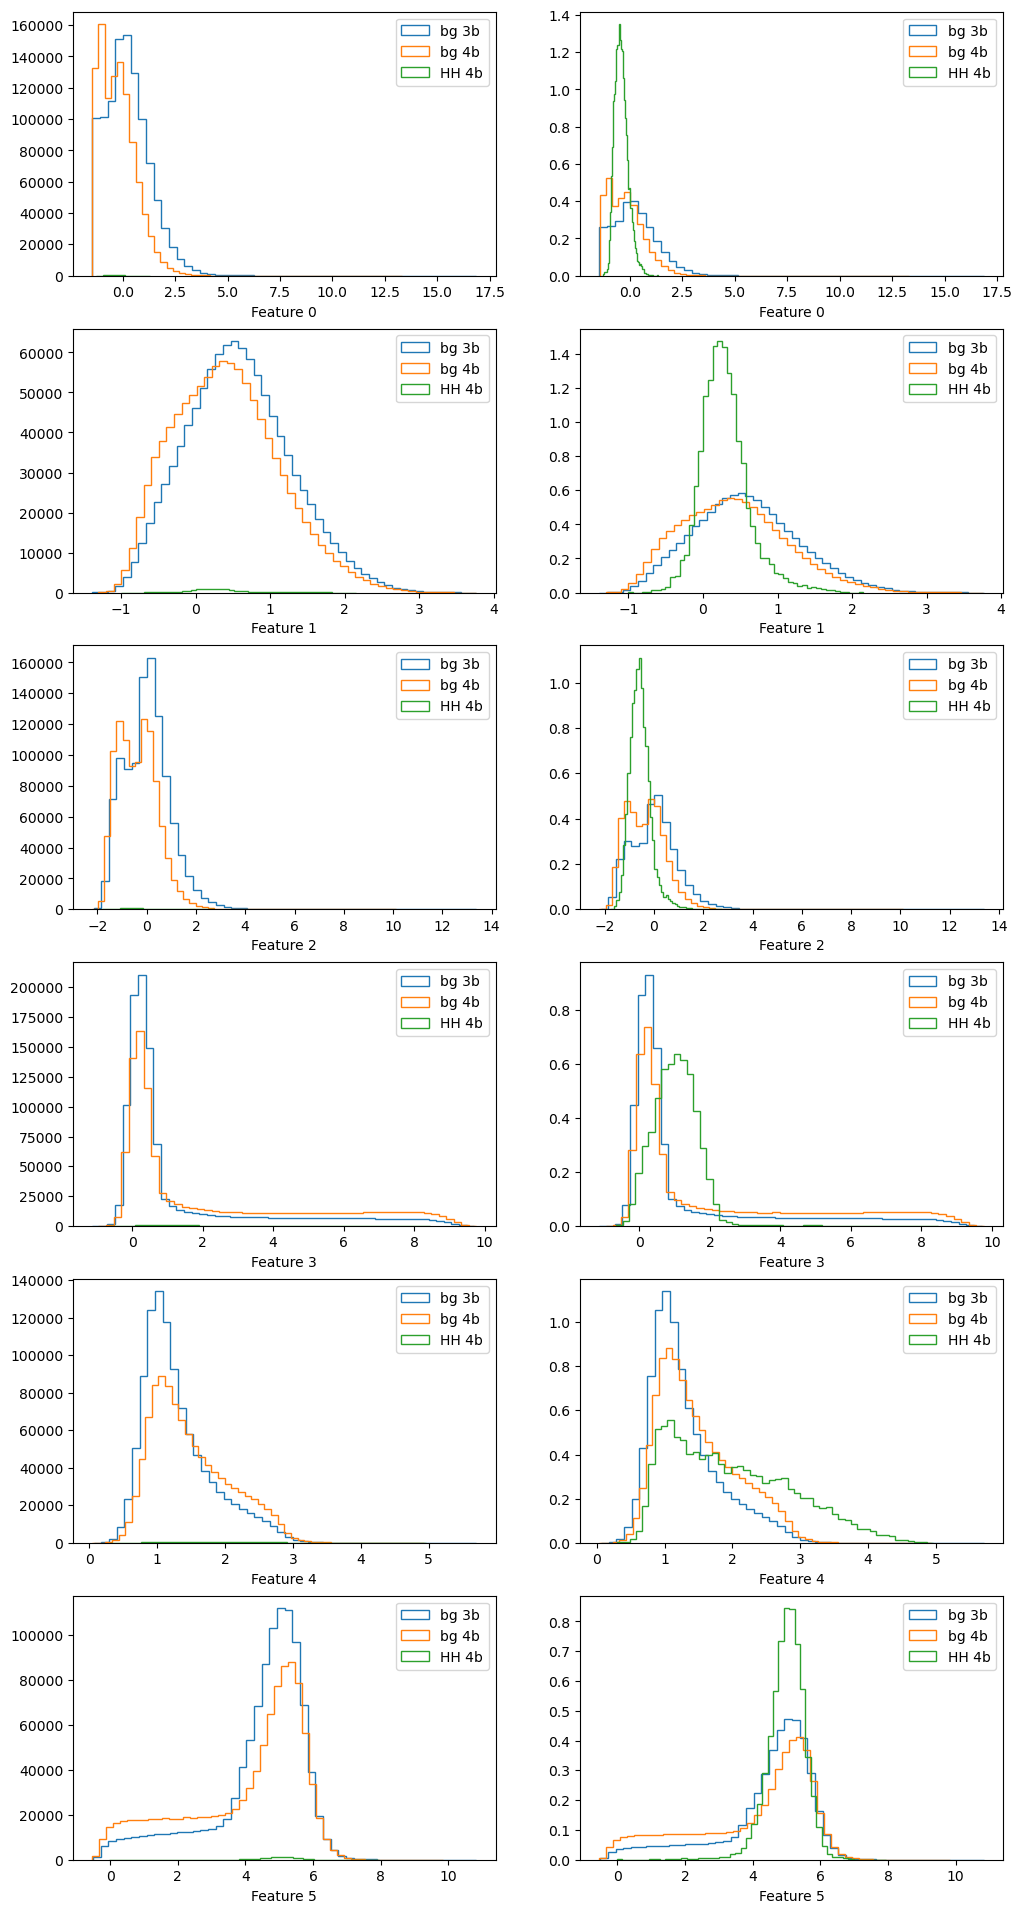

seed=52, n_samples=50000


Seed set to 52


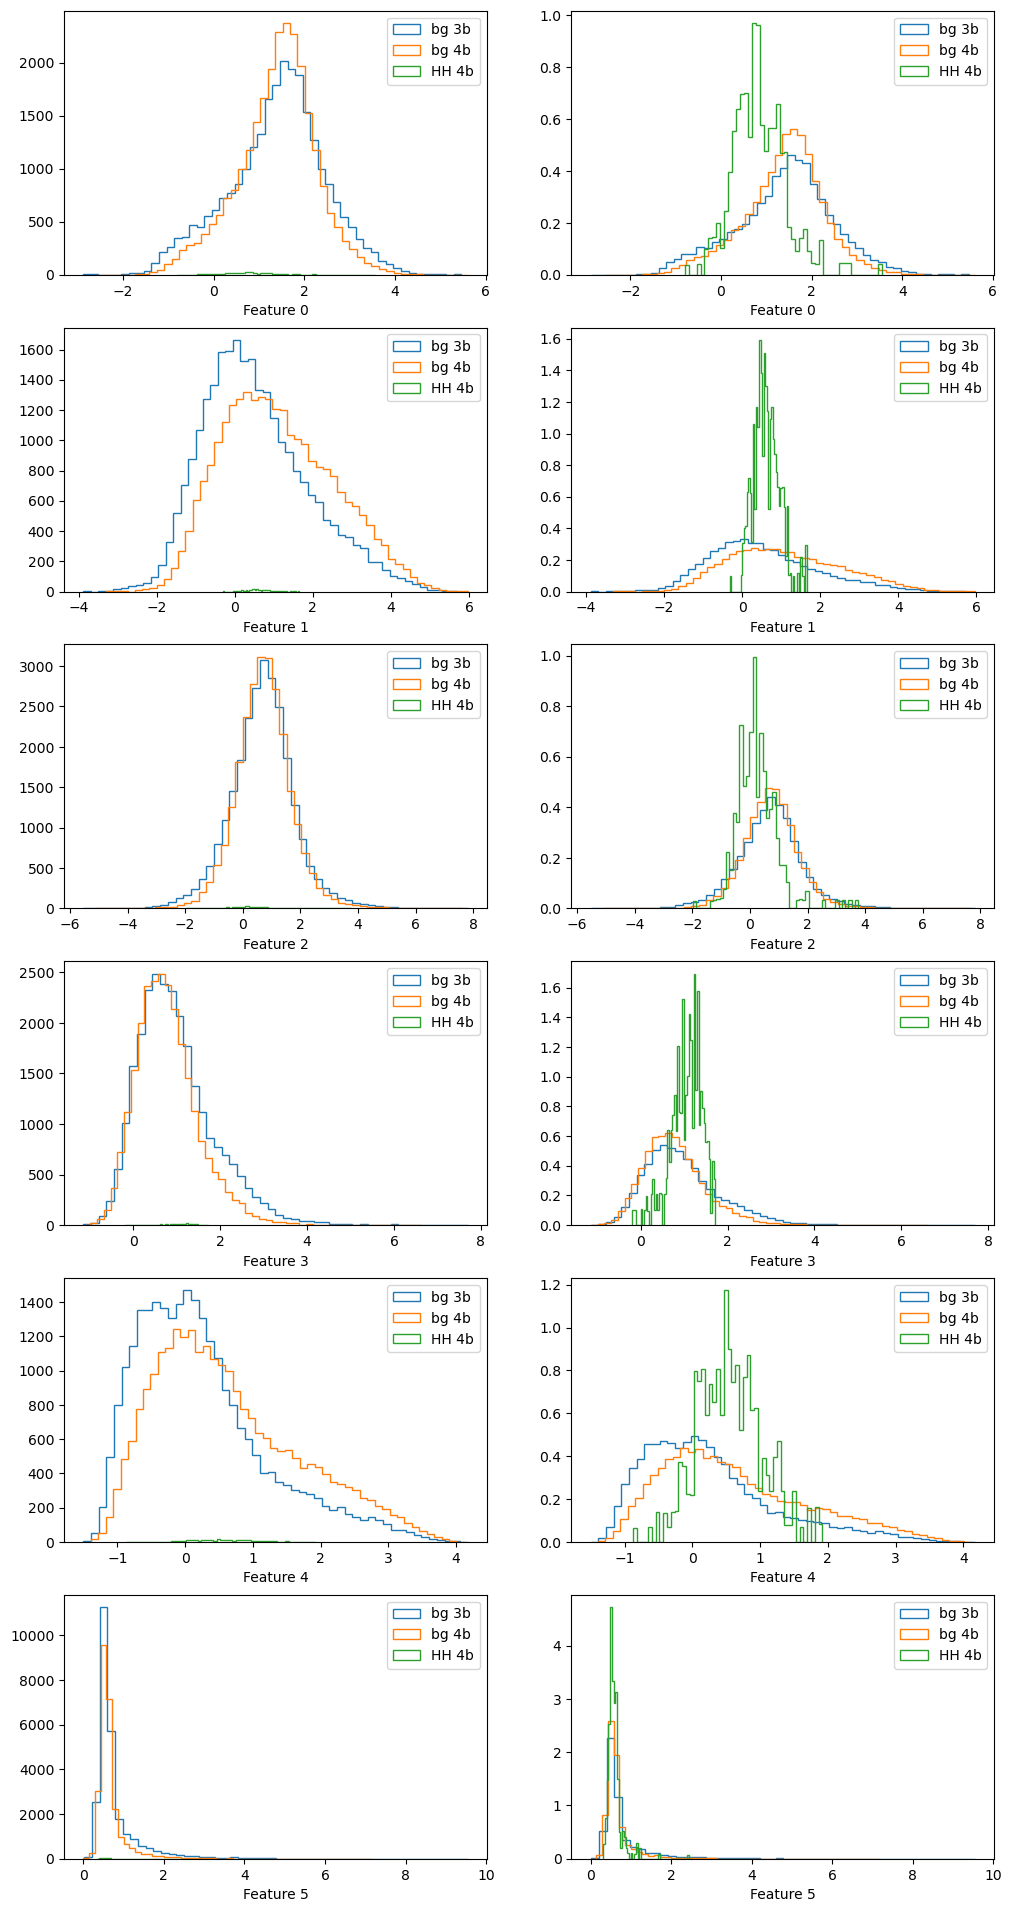

seed=52, n_samples=250000


Seed set to 52


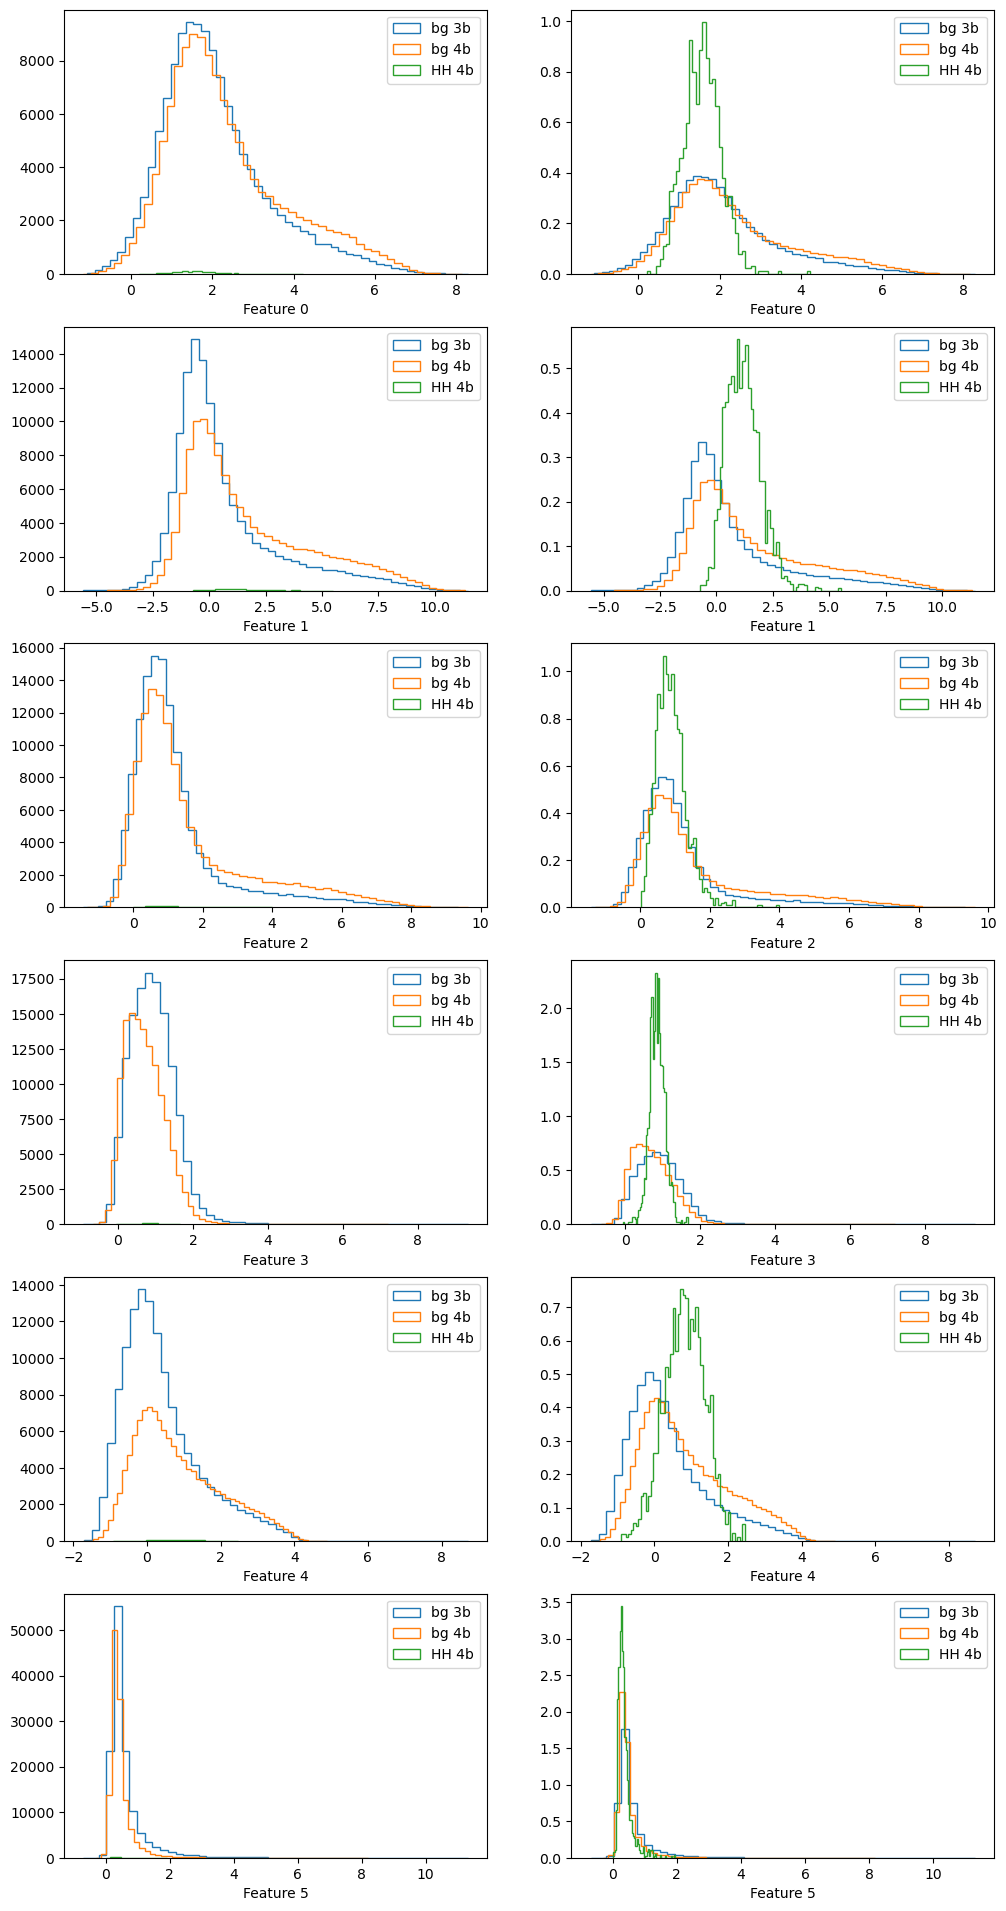

seed=52, n_samples=2000000


Seed set to 52


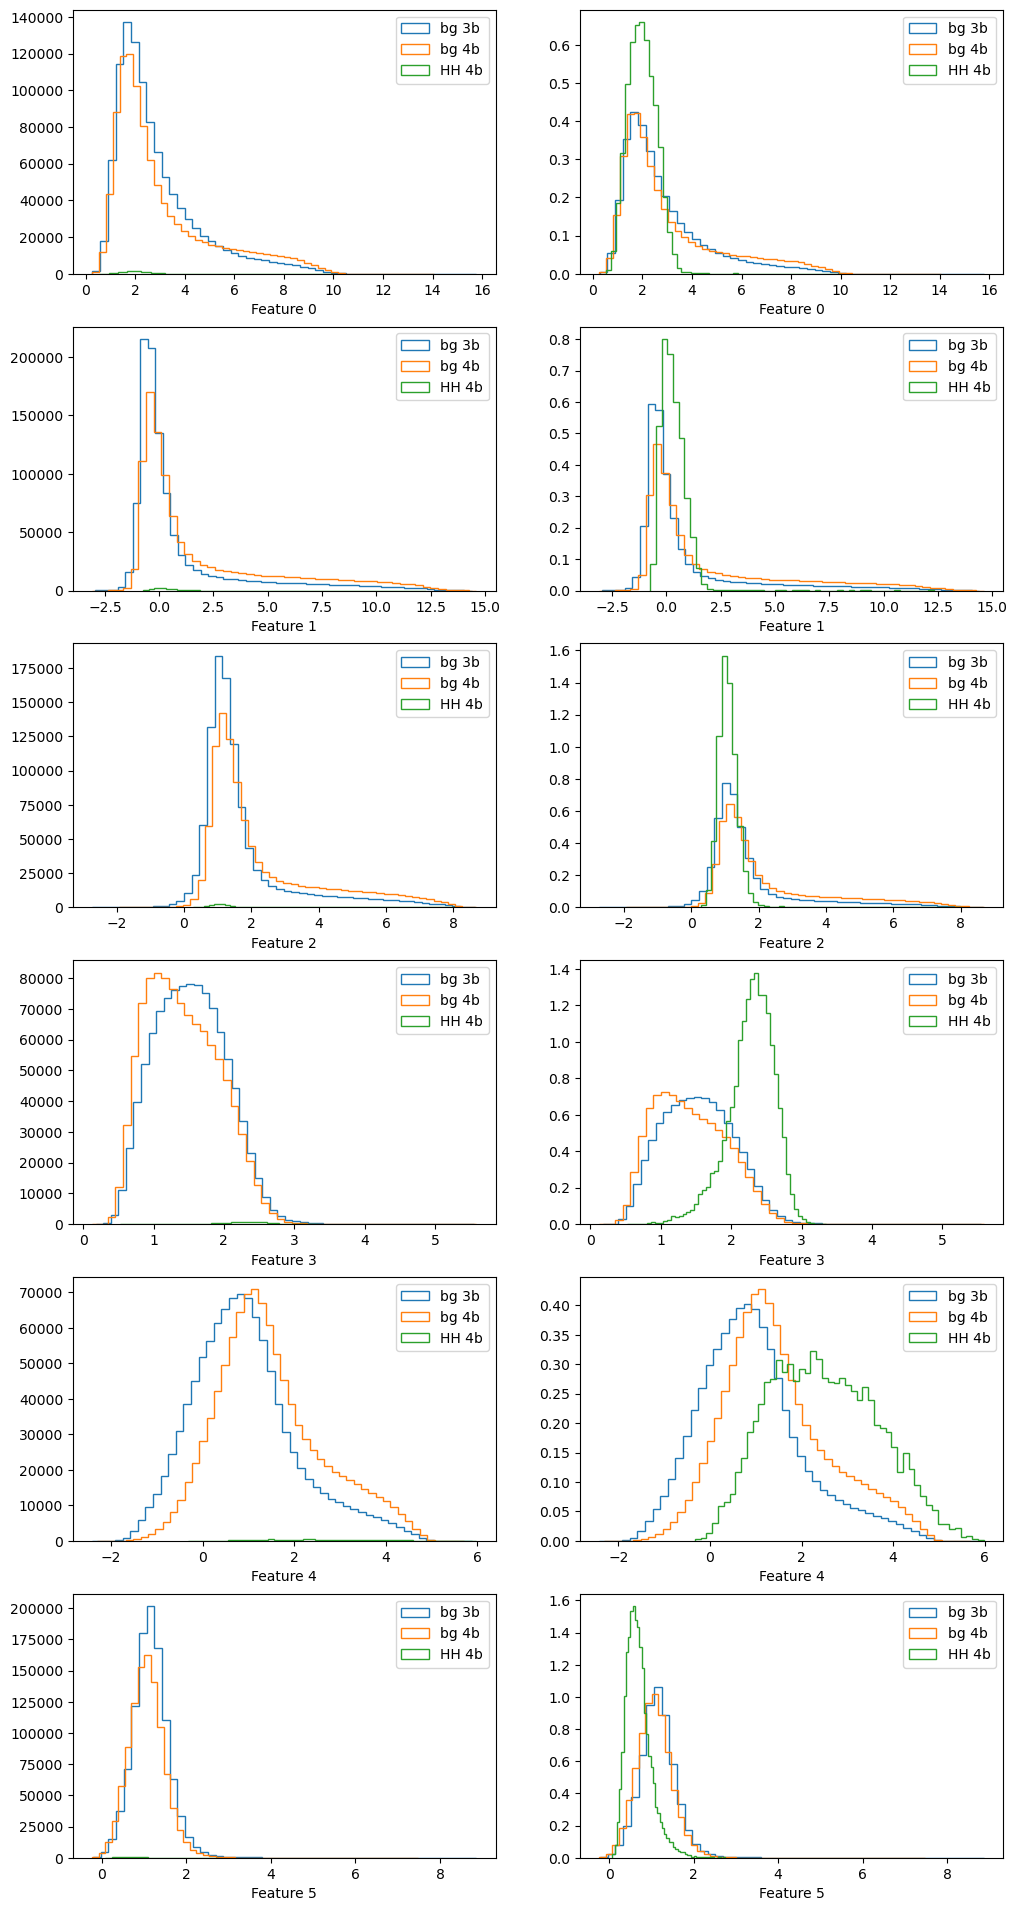

seed=62, n_samples=50000


Seed set to 62


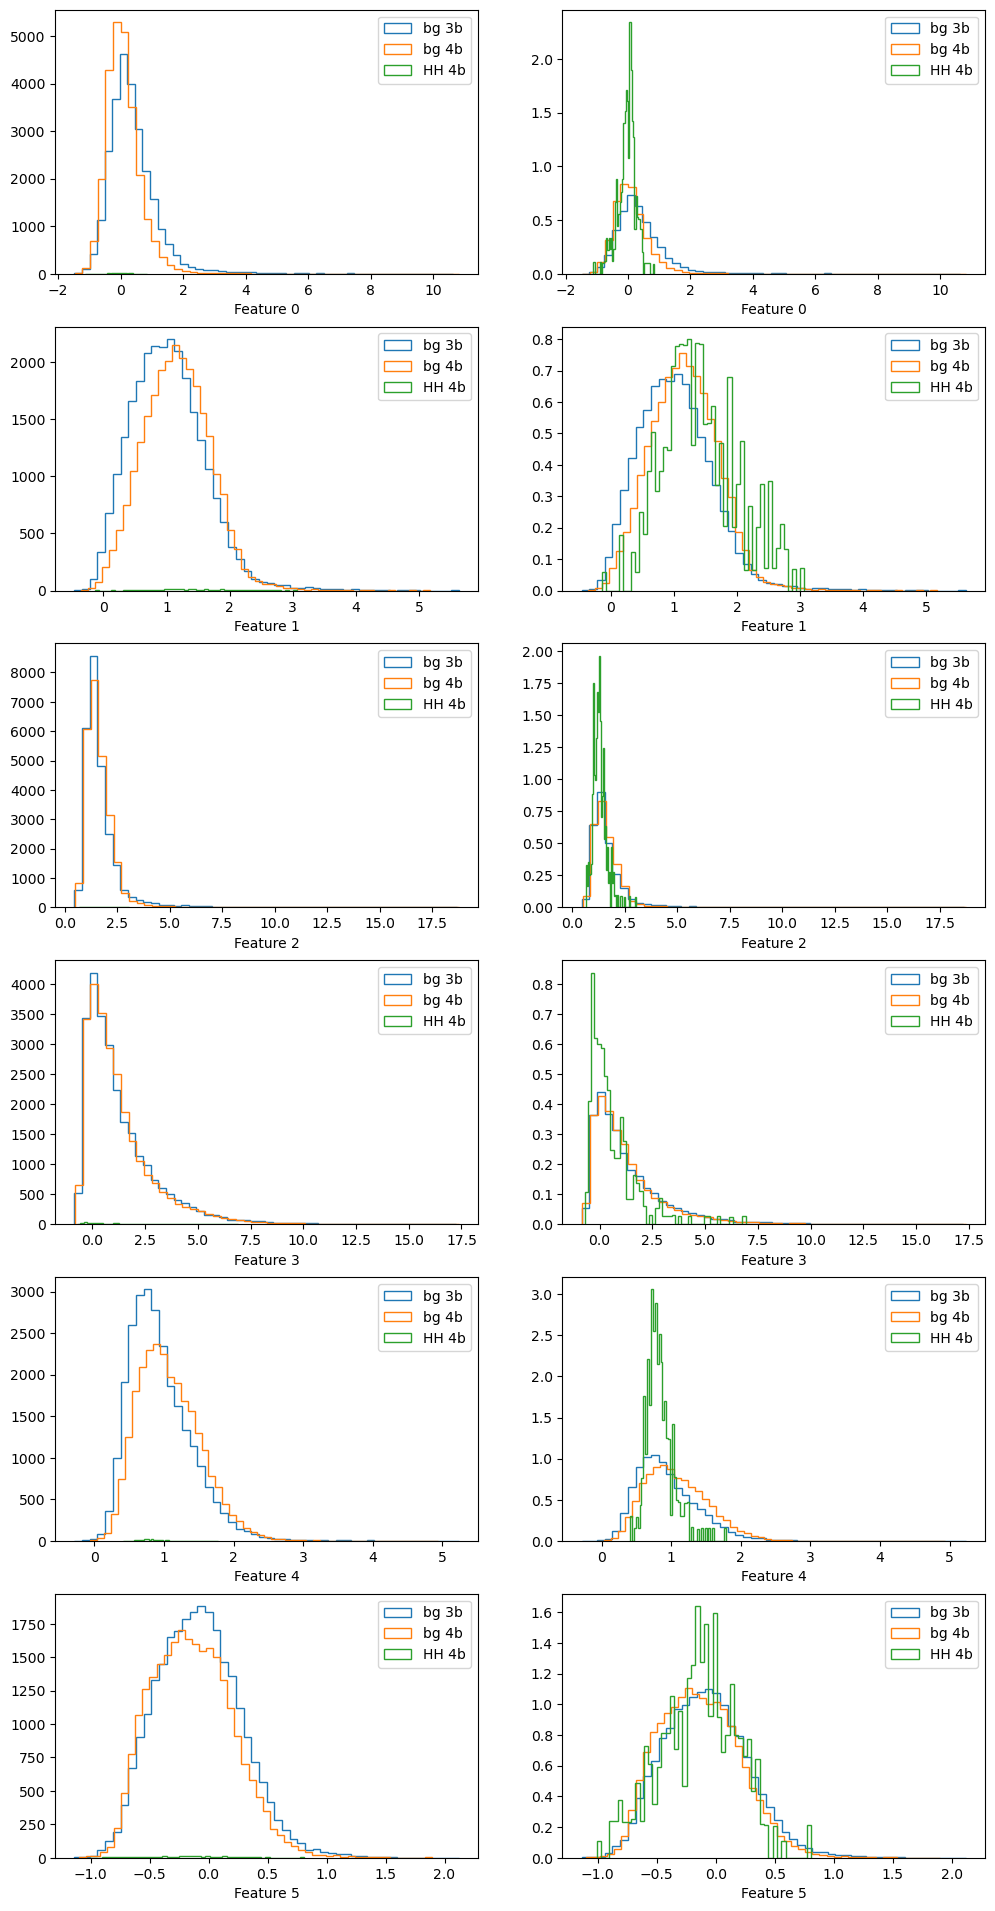

seed=62, n_samples=250000


Seed set to 62


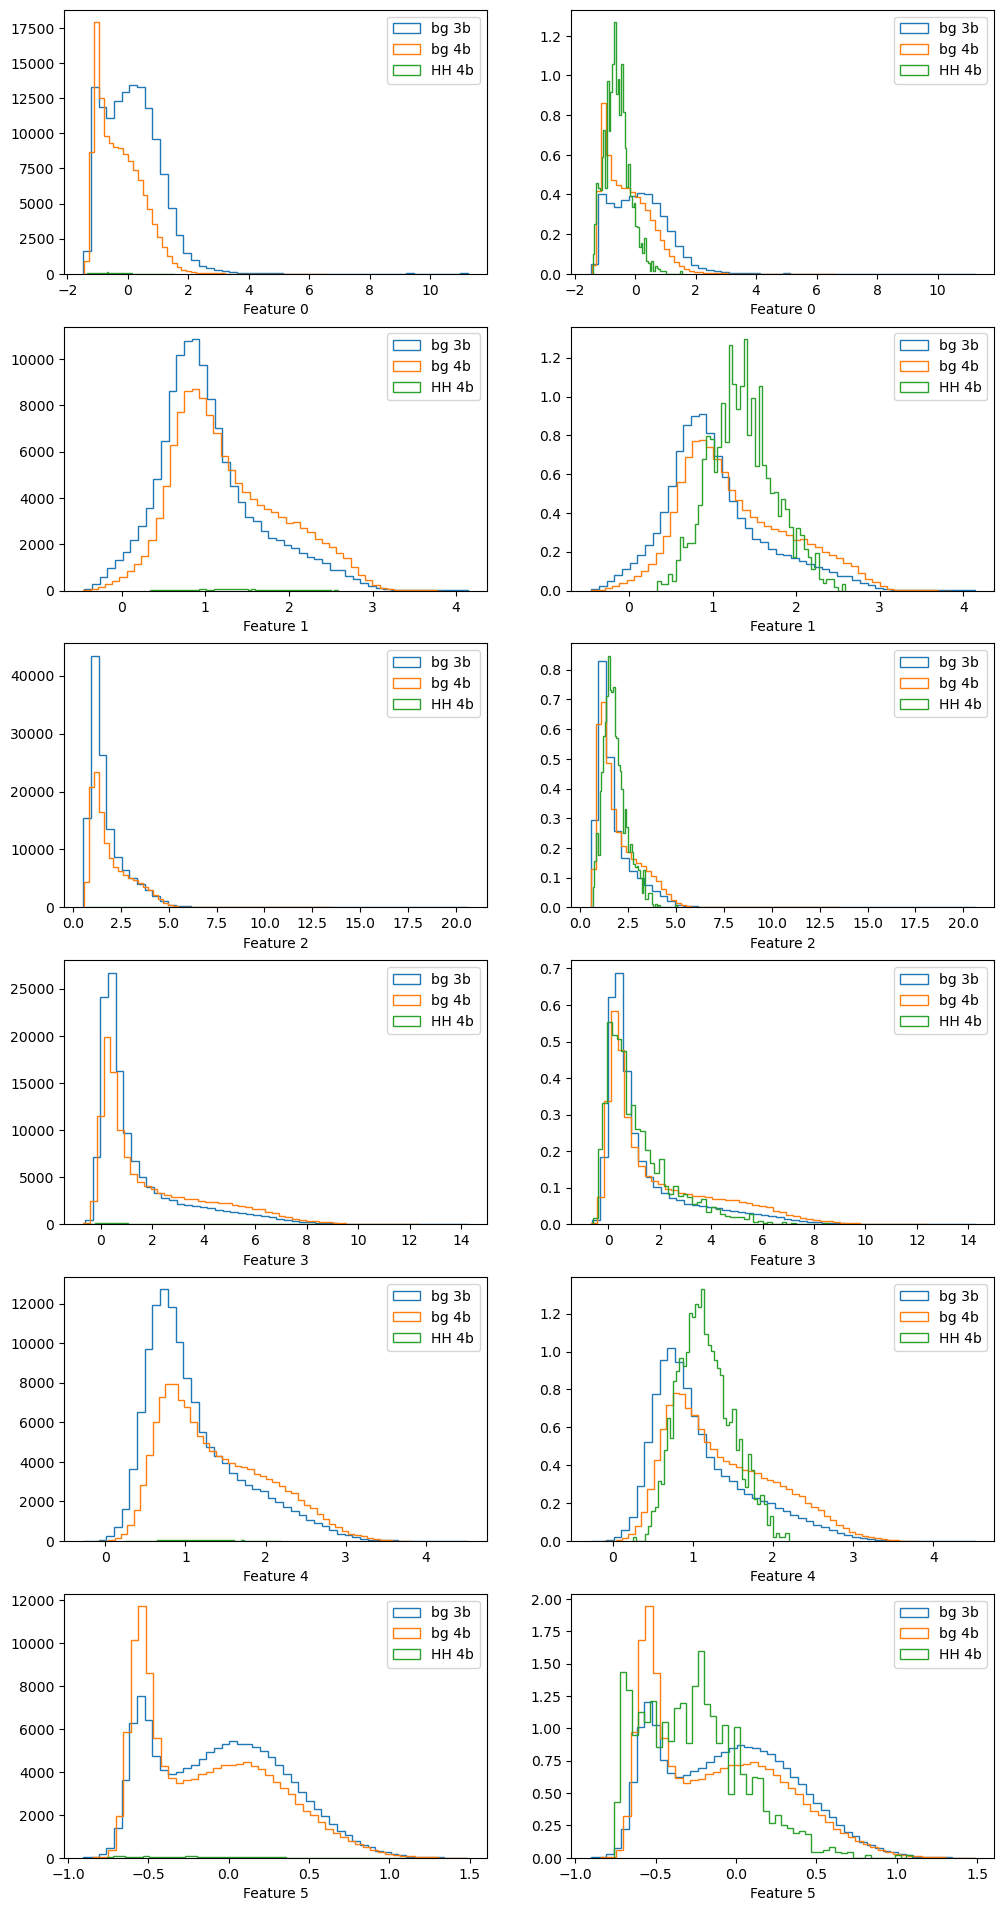

seed=62, n_samples=2000000


Seed set to 62


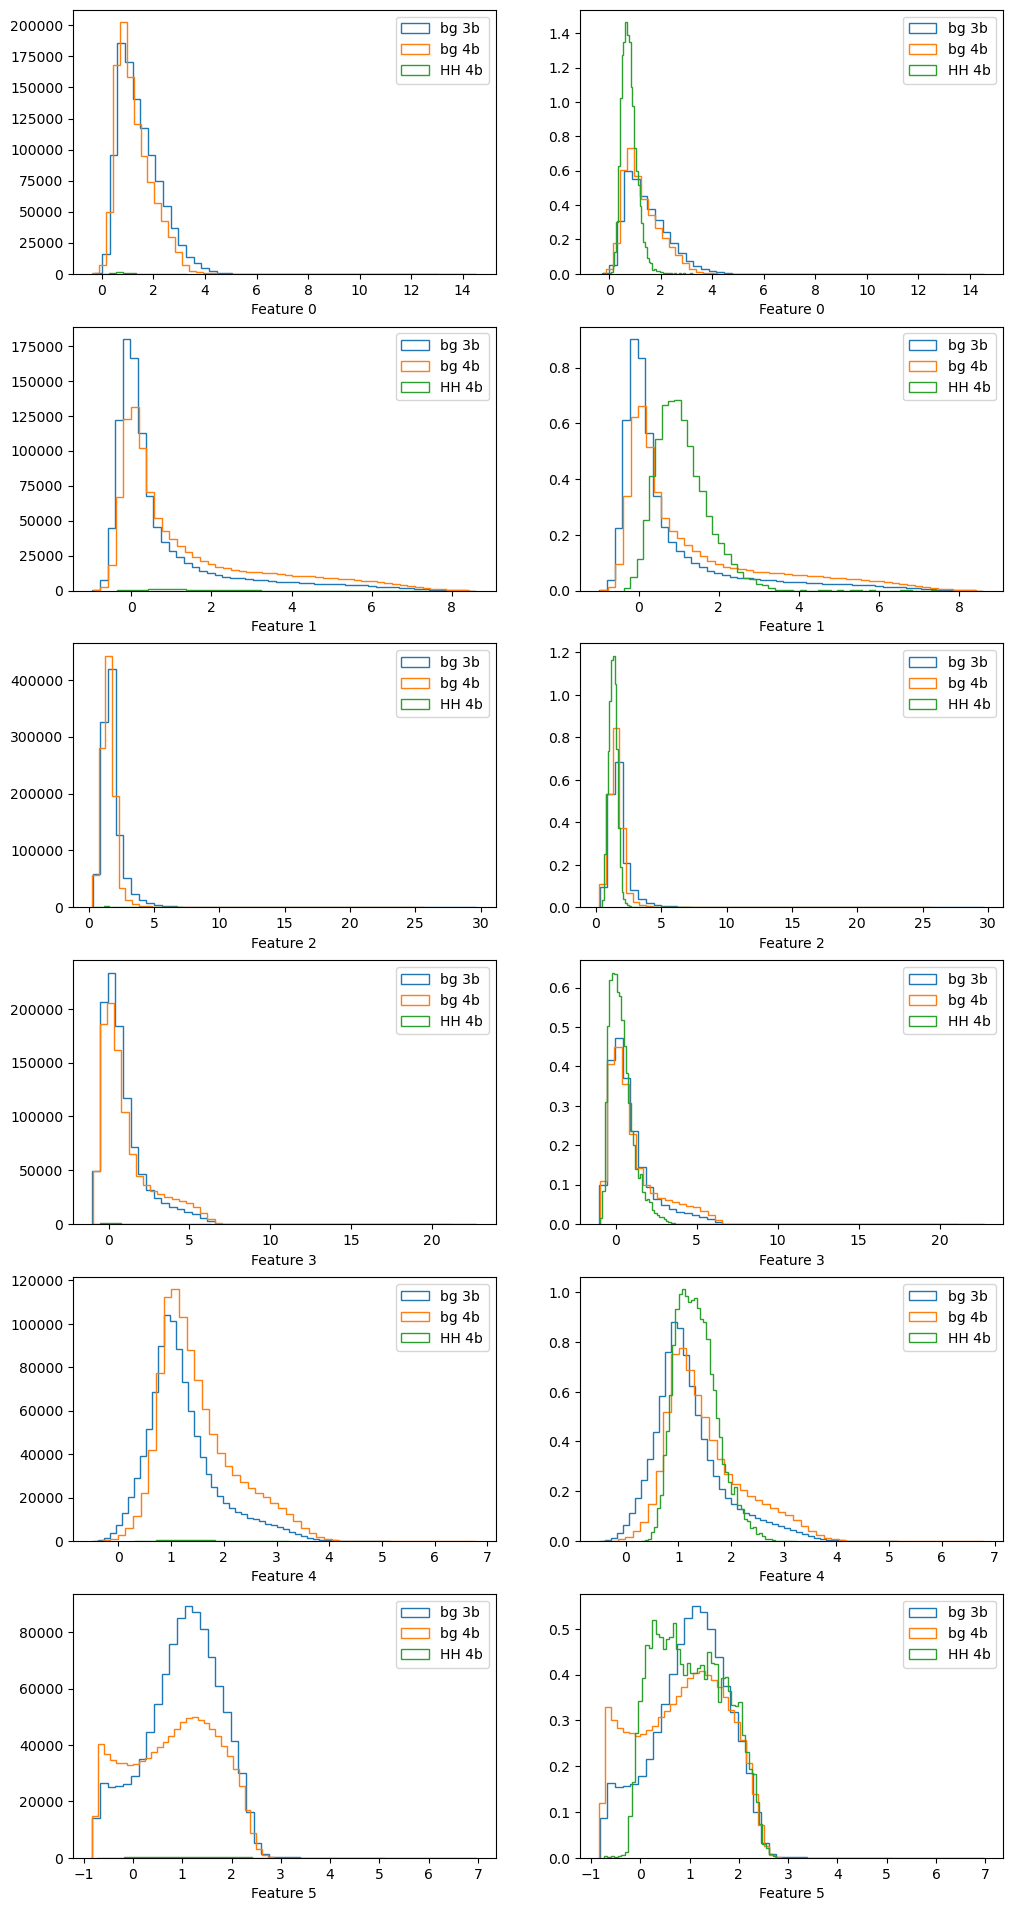

seed=72, n_samples=50000


Seed set to 72


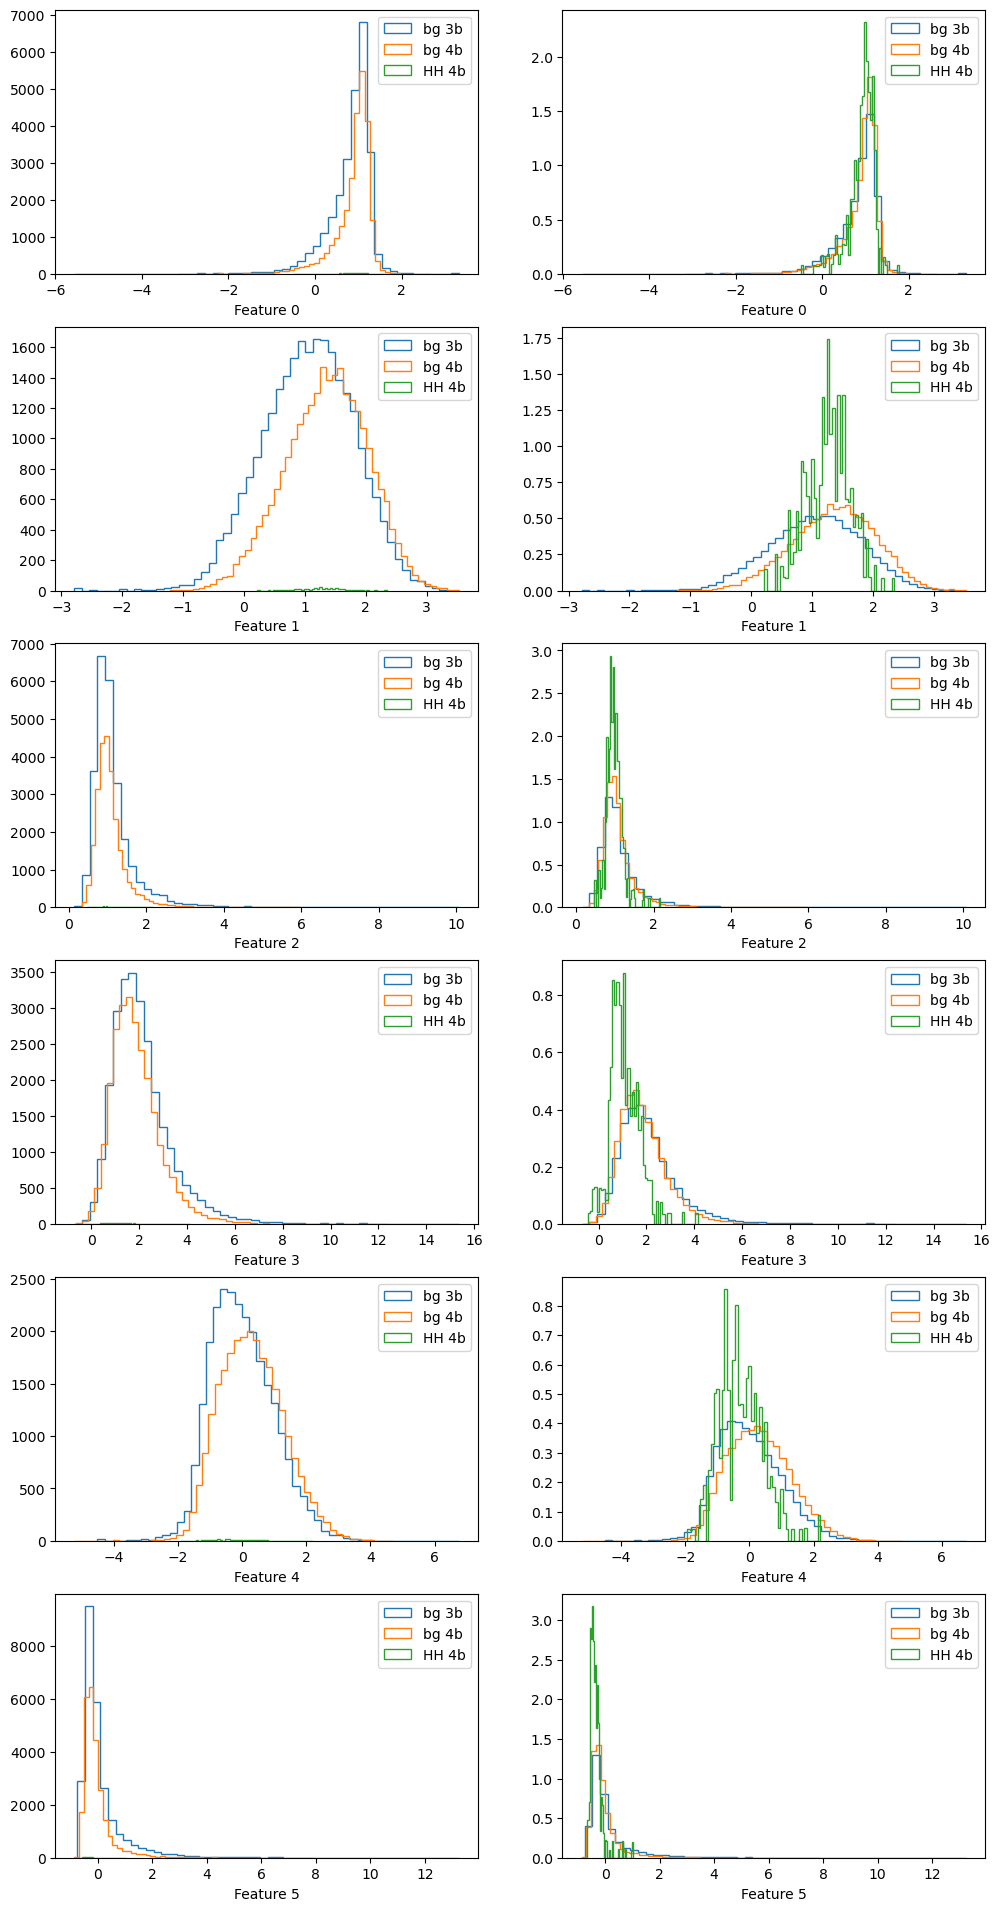

seed=72, n_samples=250000


Seed set to 72


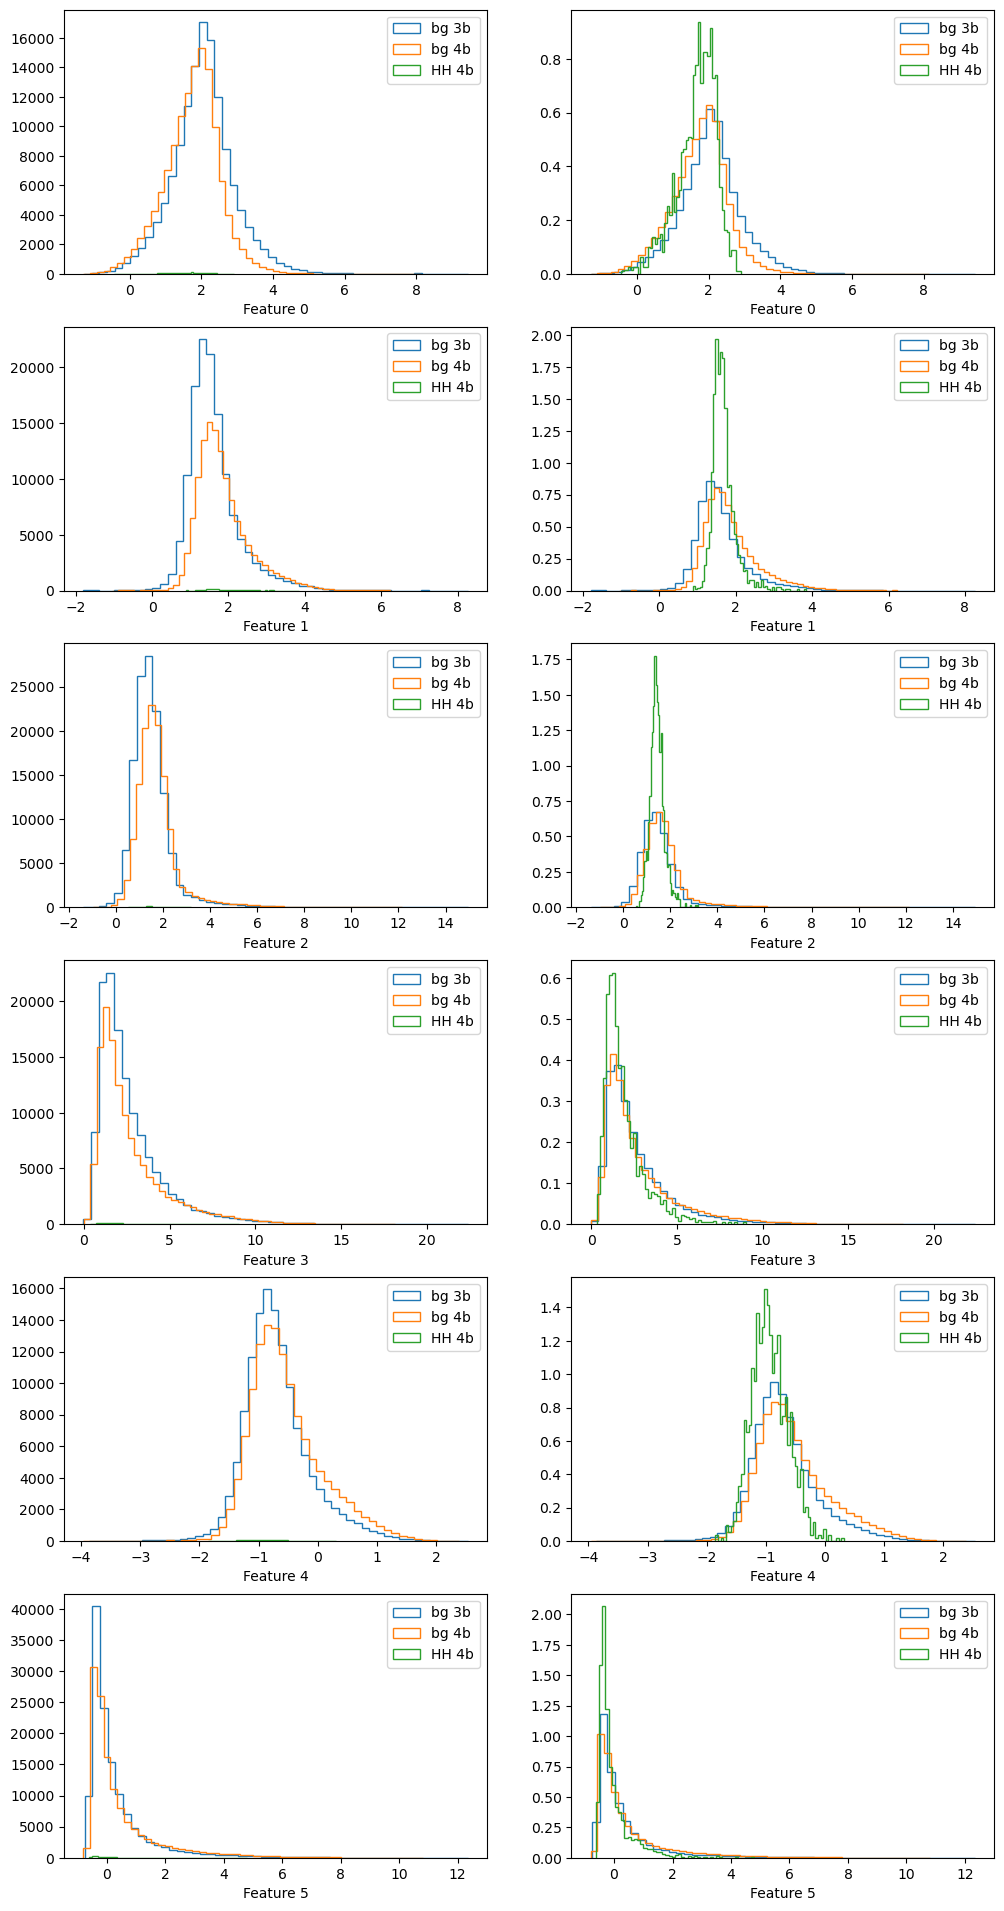

seed=72, n_samples=2000000


Seed set to 72


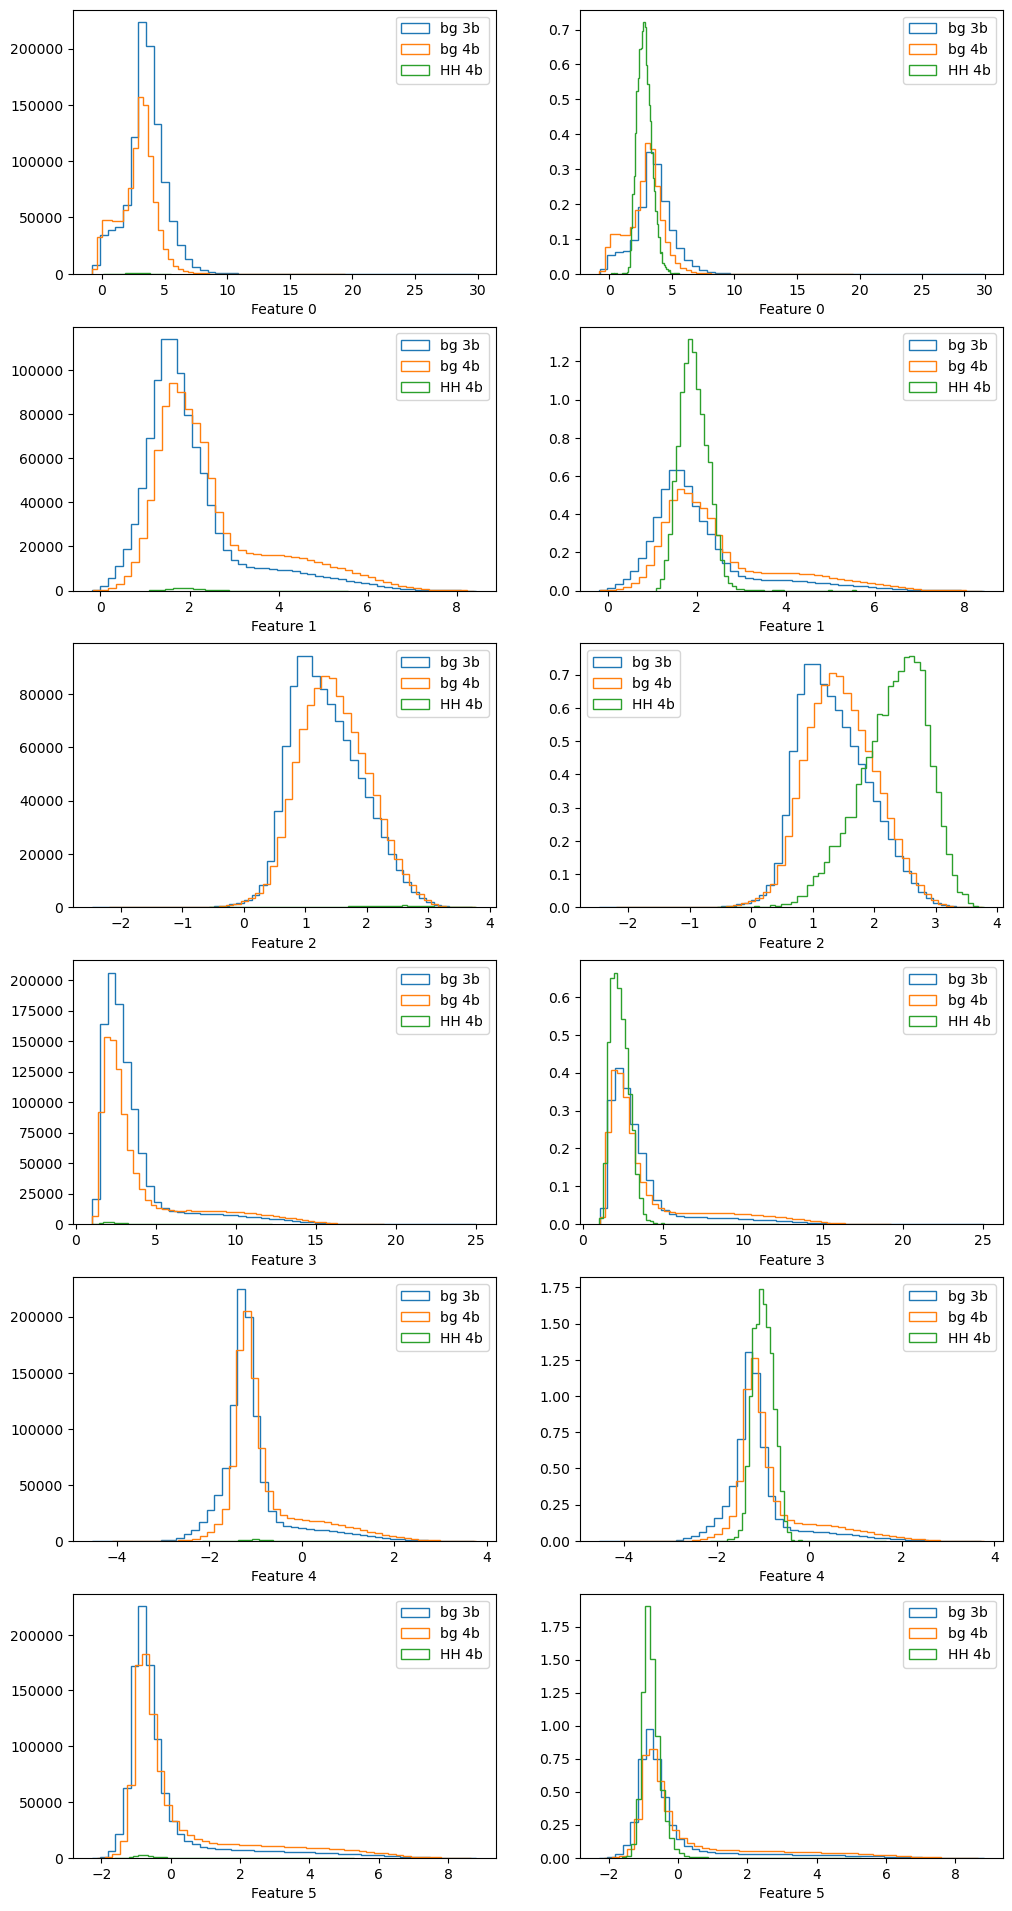

seed=82, n_samples=50000


Seed set to 82


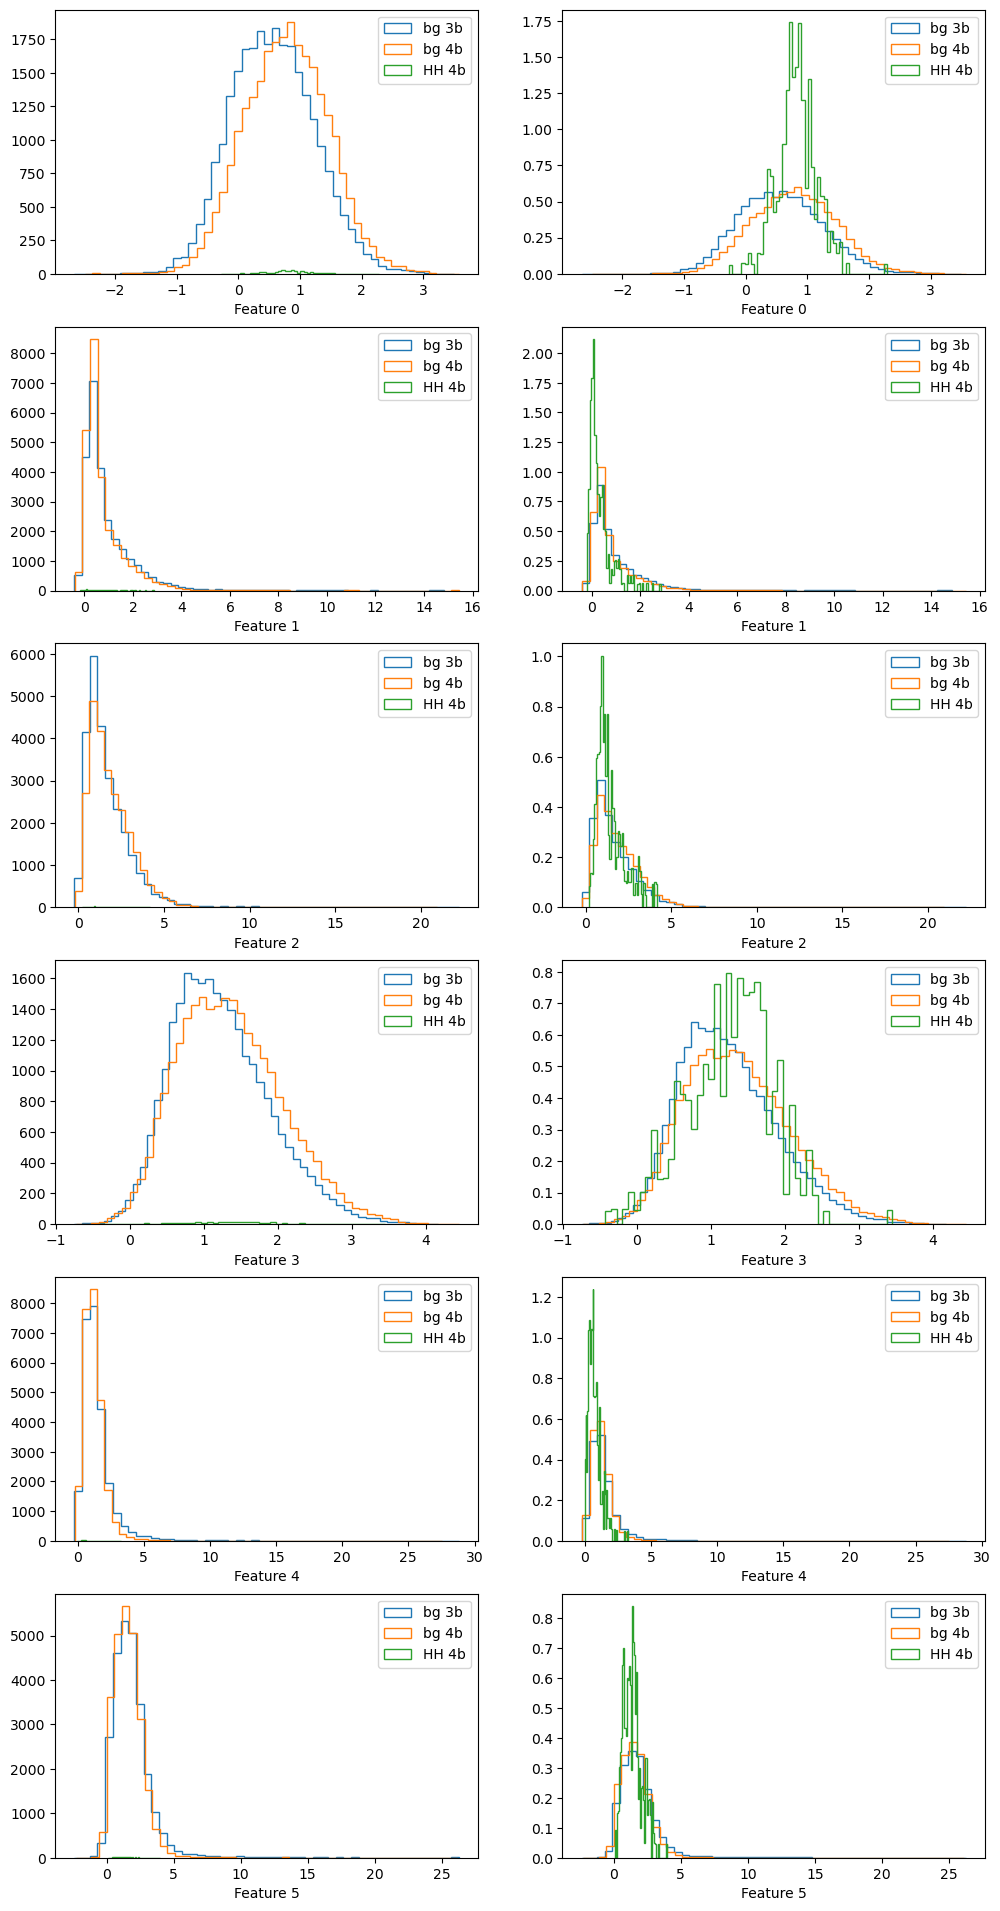

seed=82, n_samples=250000


Seed set to 82


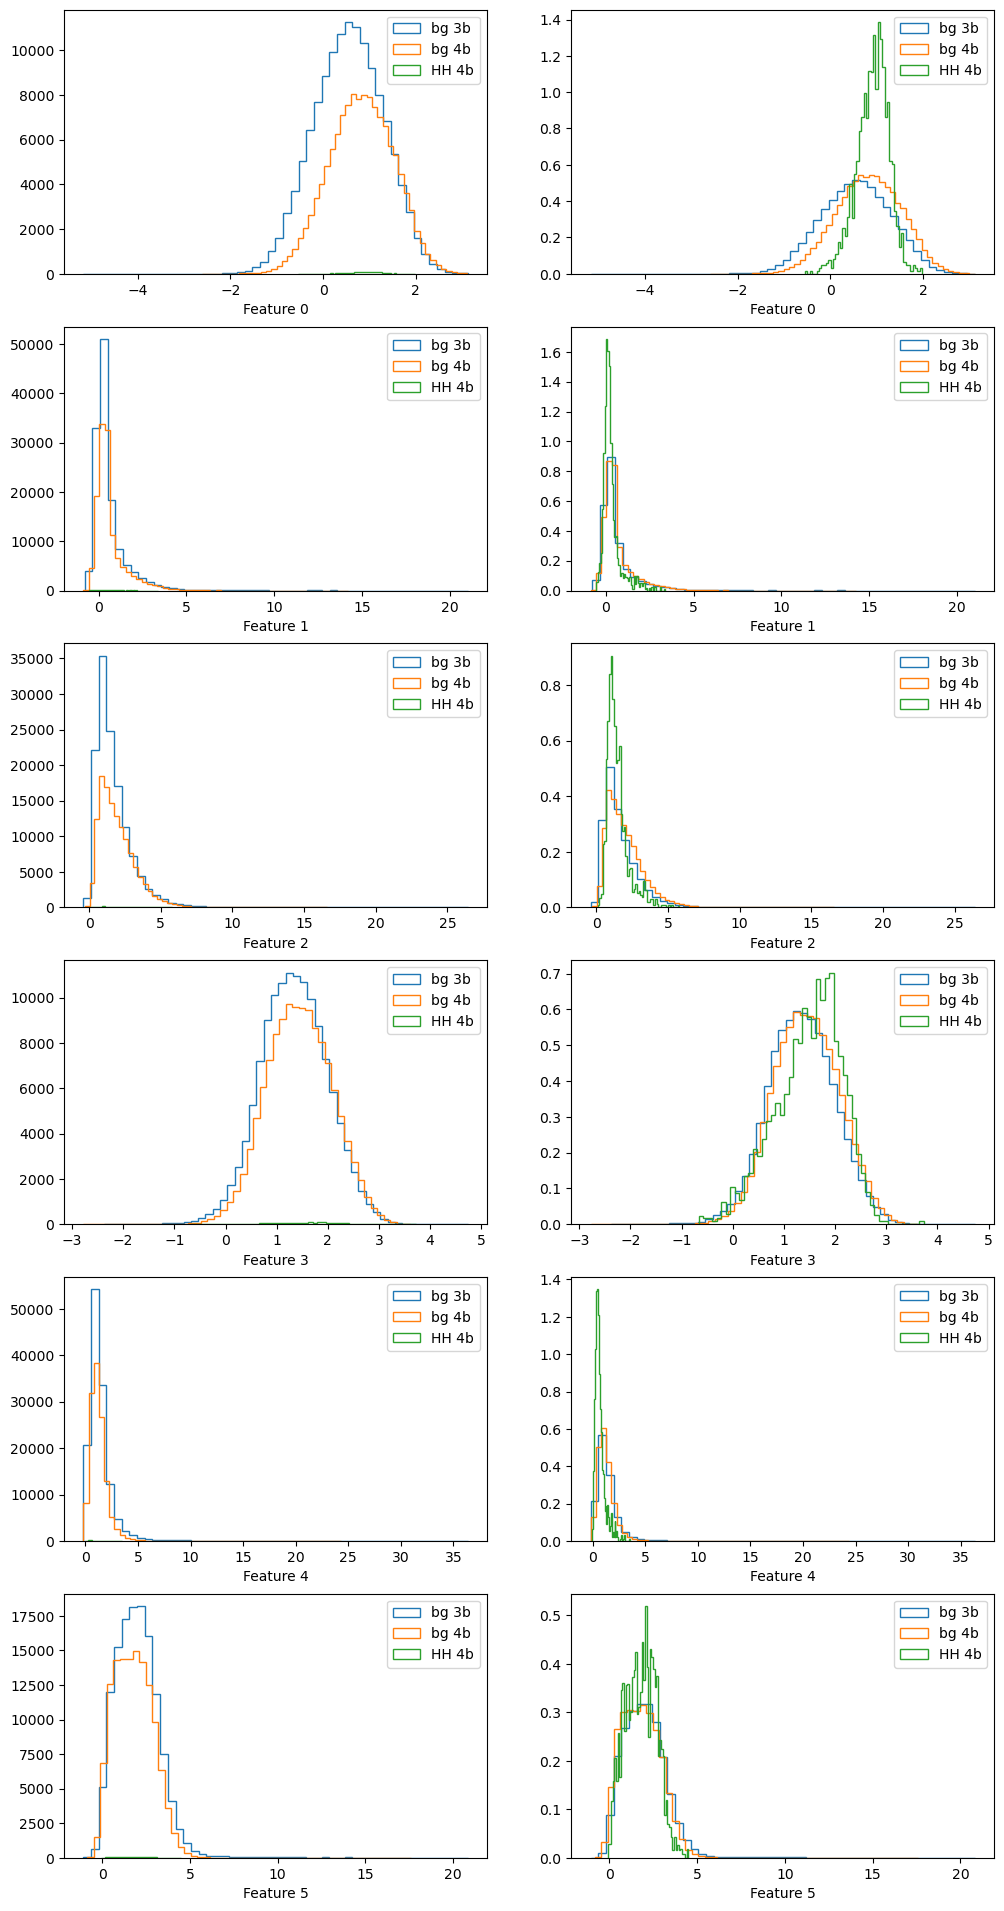

seed=82, n_samples=2000000


Seed set to 82


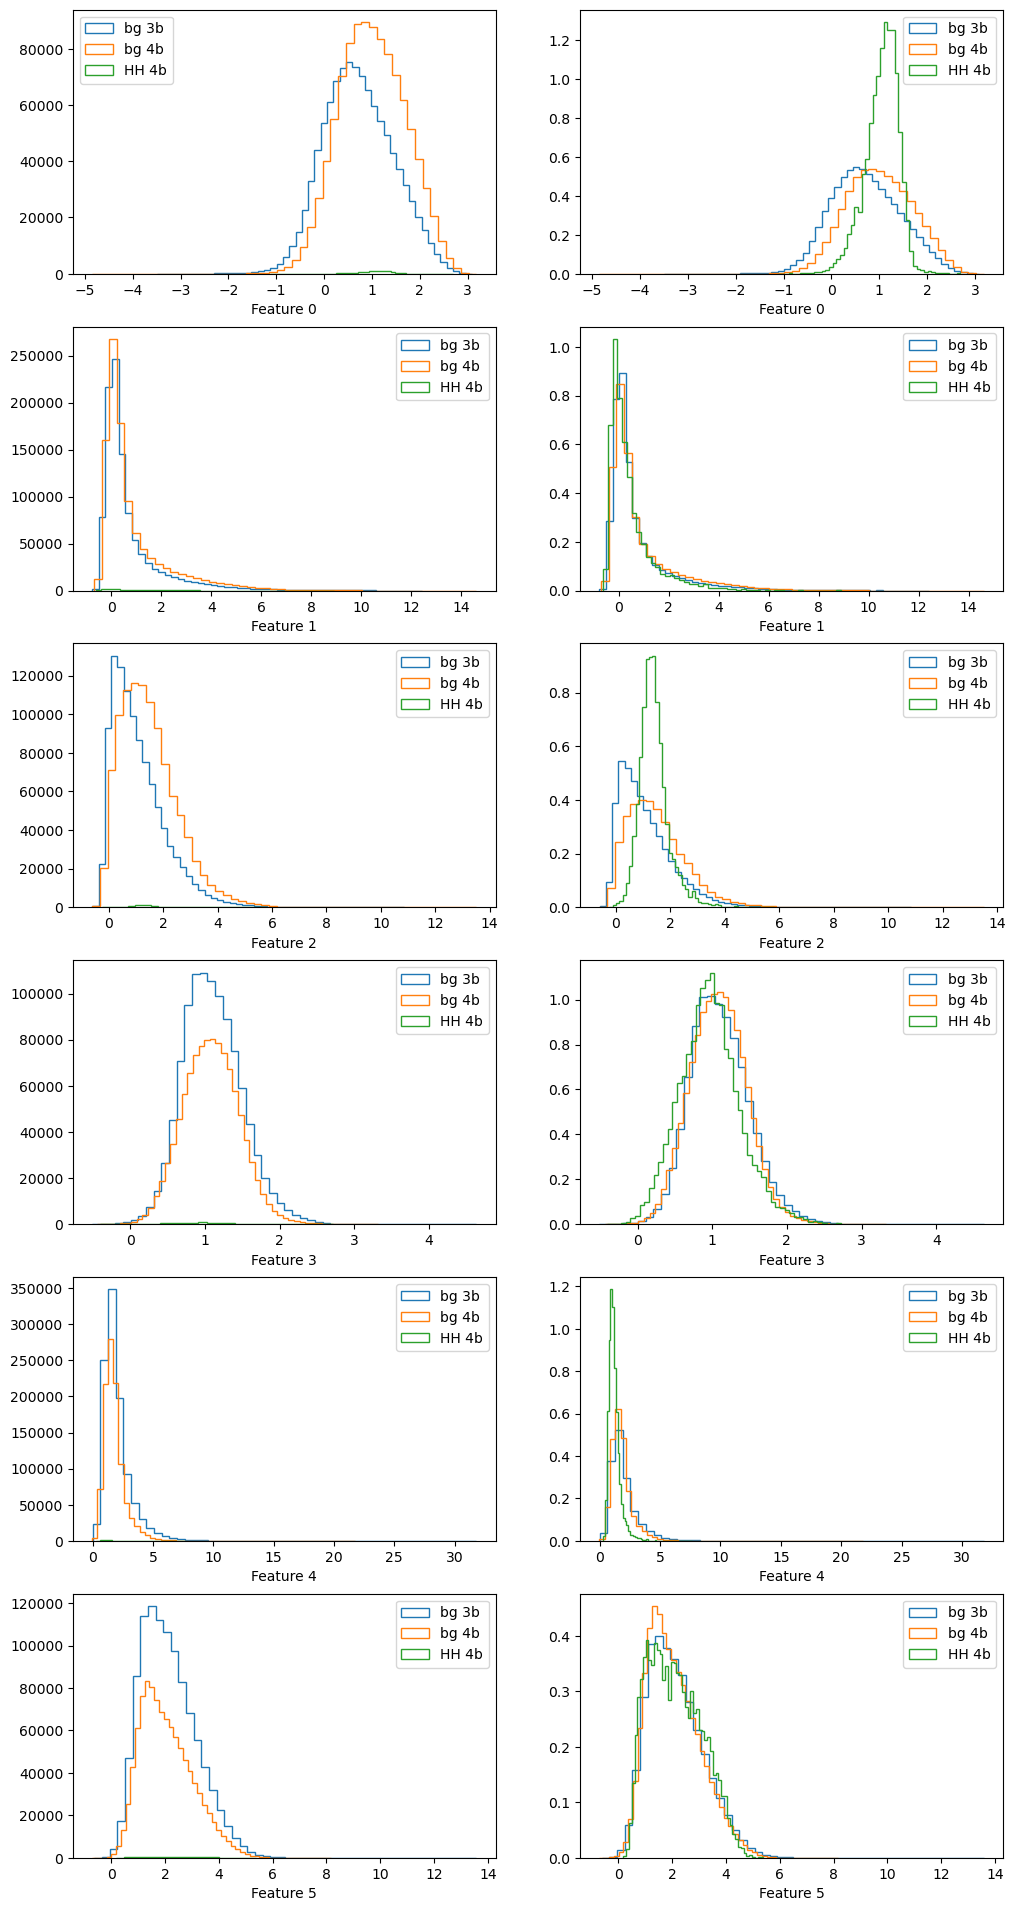

seed=92, n_samples=50000


Seed set to 92


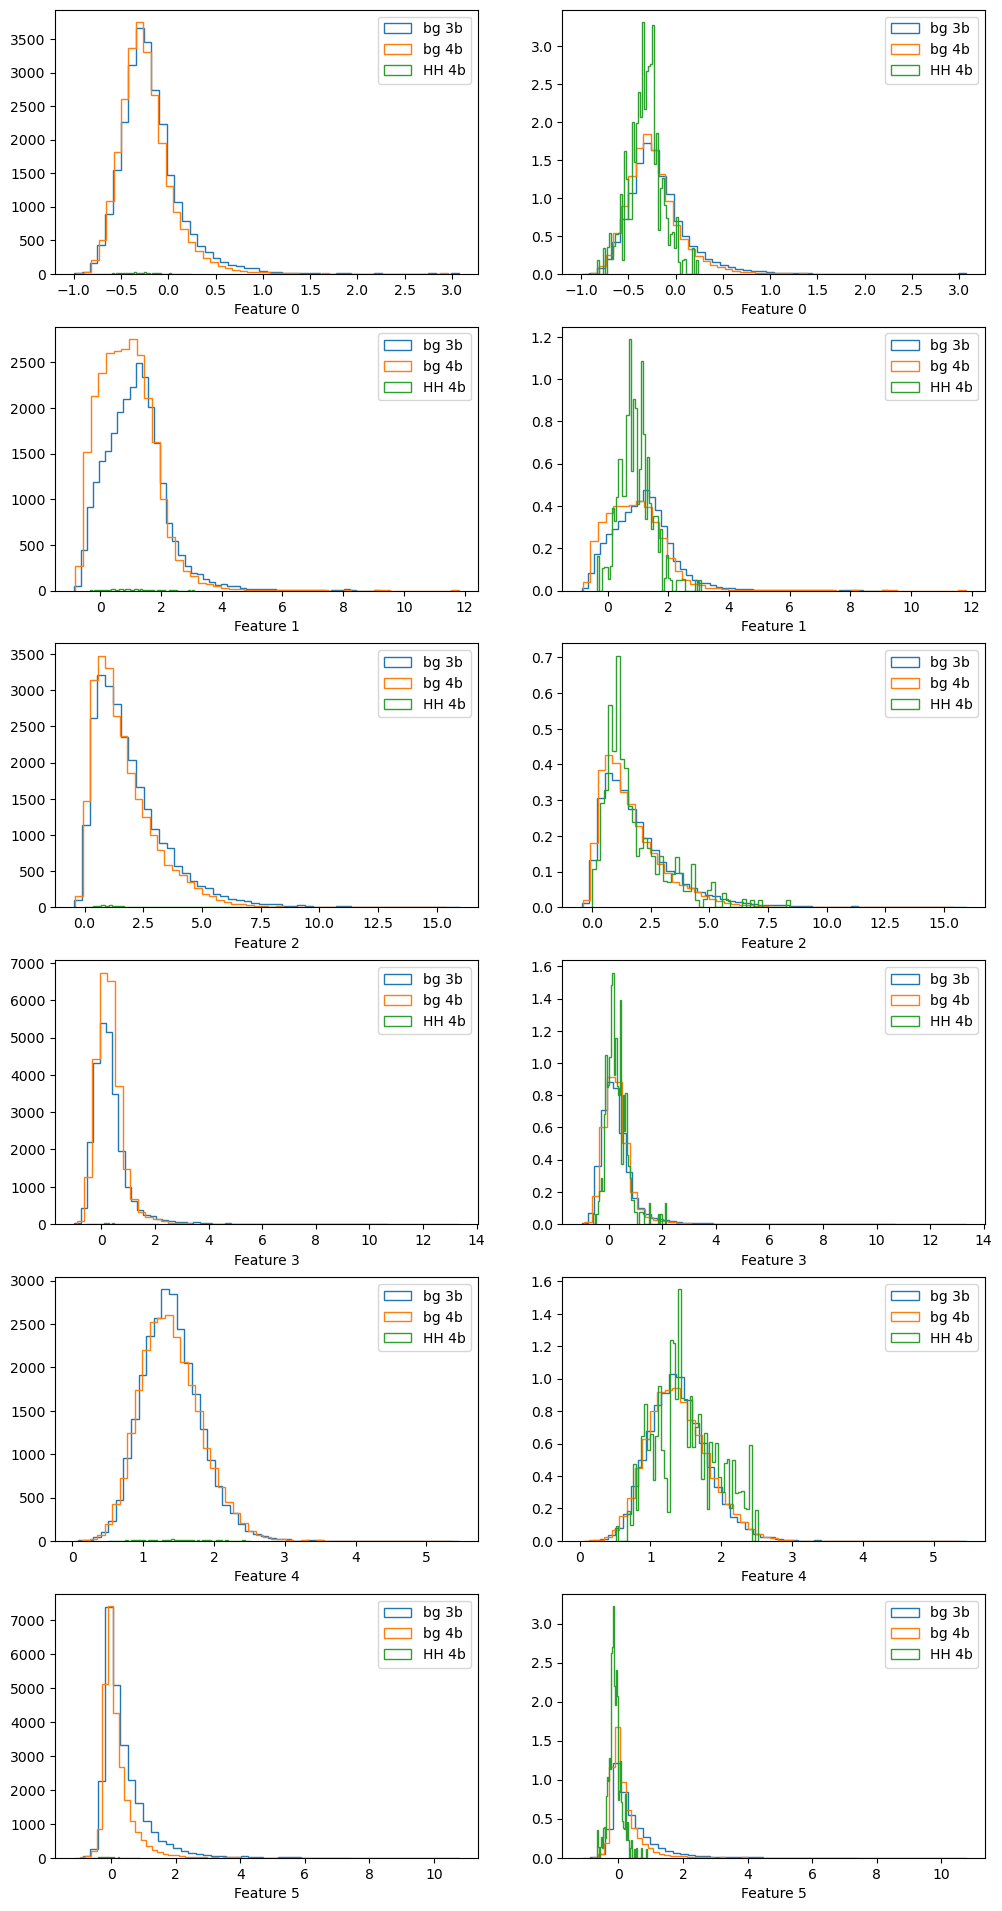

seed=92, n_samples=250000


Seed set to 92


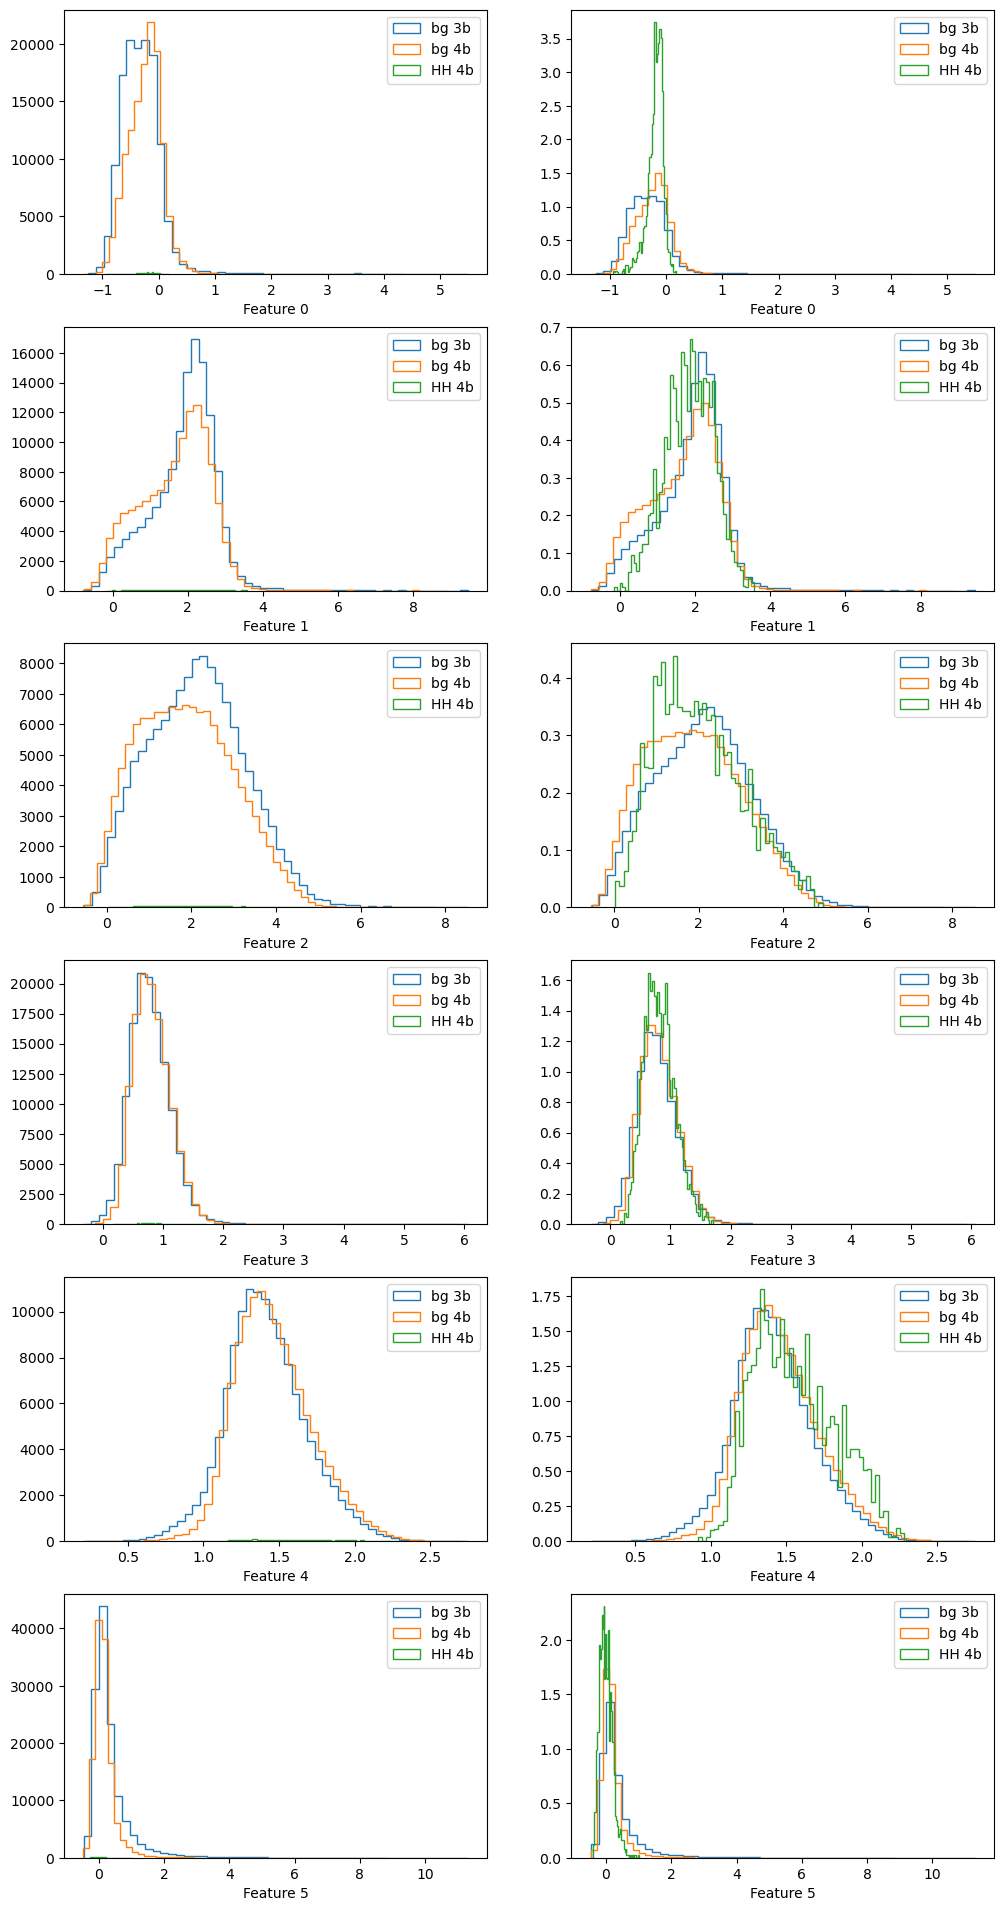

seed=92, n_samples=2000000


Seed set to 92


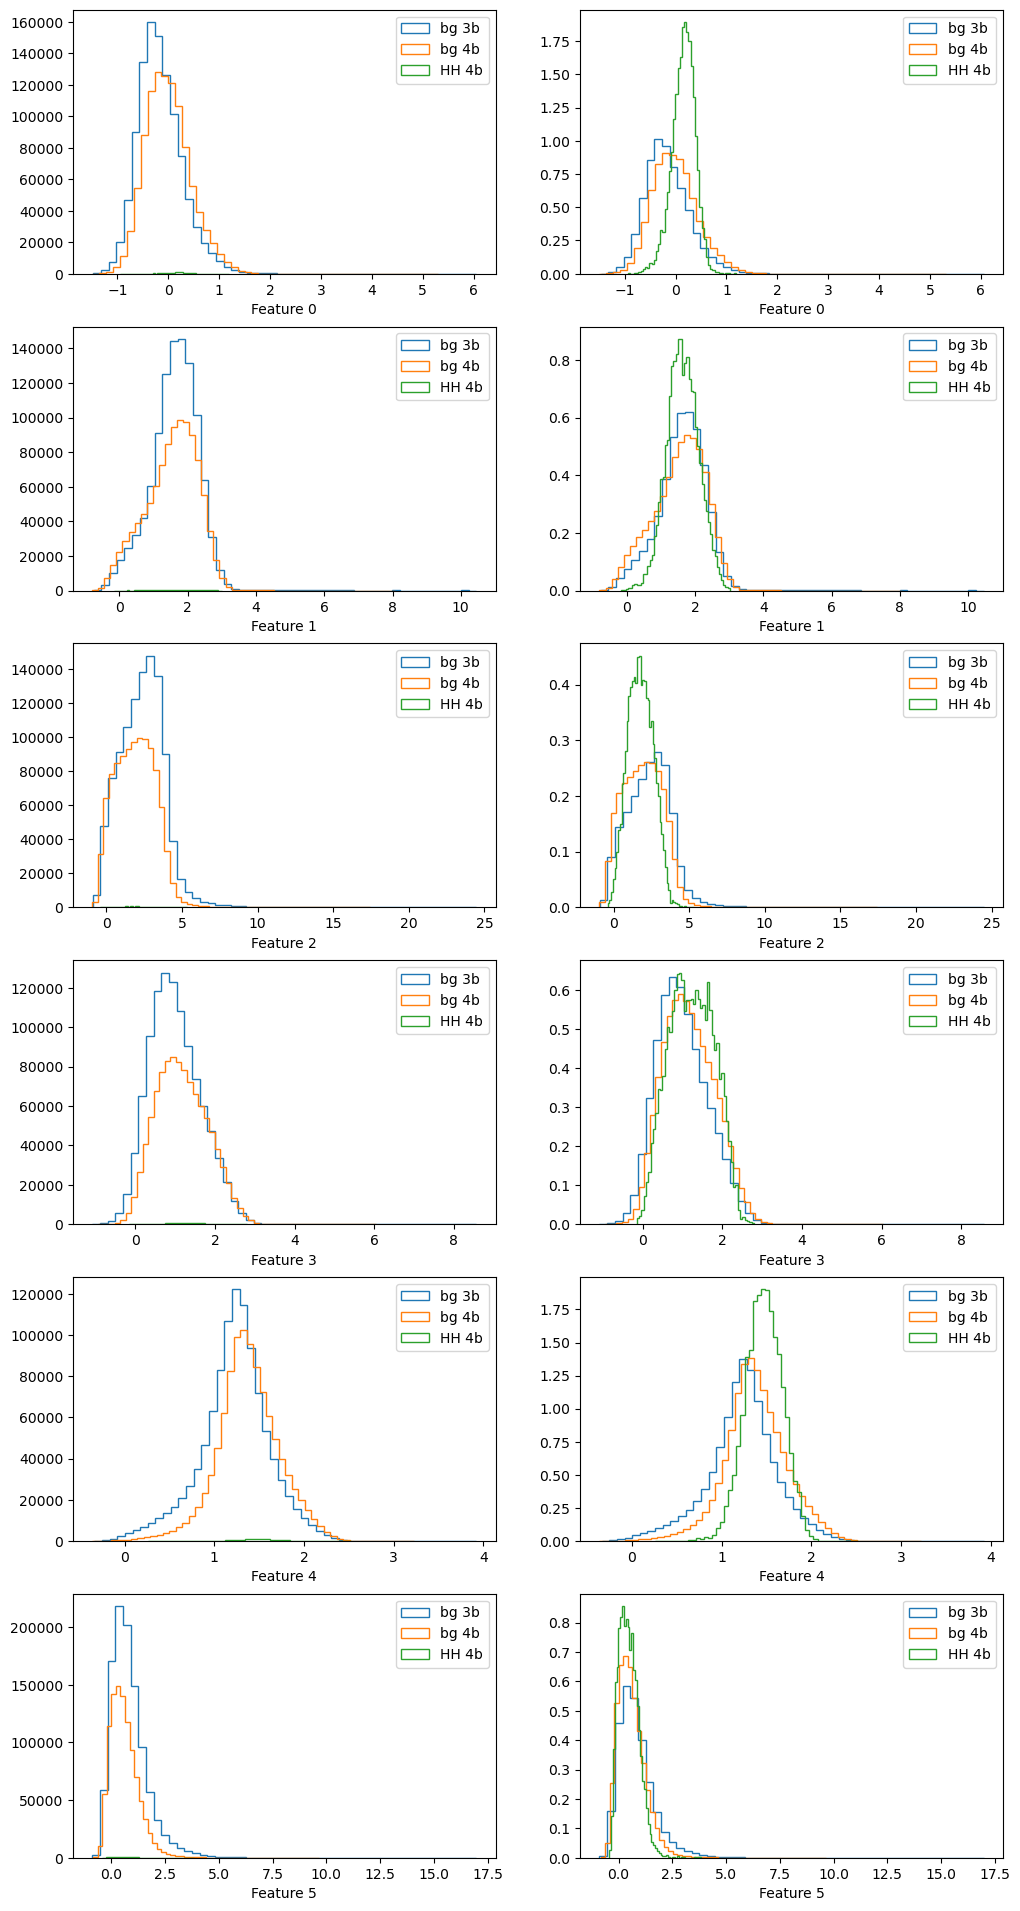

In [17]:
from code_fragments import att_q_repr_hist

for seed in [42, 52, 62, 72, 82, 92]:
    for n_samples in [50000, 250000, 2000000]:
        print(f"seed={seed}, n_samples={n_samples}")
        for signal_ratio in [0.01]:
            events_test = routine_1(signal_ratio, seed, n_3b=n_samples, n_all4b=n_samples, return_keys=["test"])["test"]
            att_q_repr_hist(events_test, 6)


IndexError: list index out of range

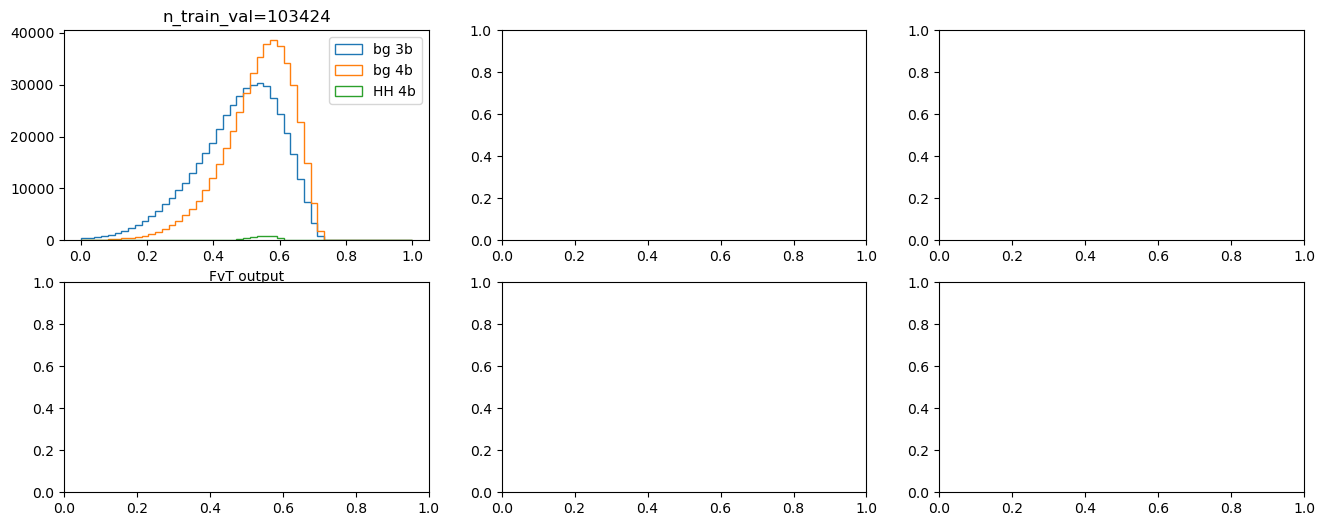

In [21]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import fvt_score_hist

config_filename = "configs/fvt_training_n_samples_1.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
seeds = config["seeds"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
n_sample_ratios = config["n_sample_ratios"]

for seed in seeds:
    _, dinfo_test = generate_tt_dataset(
            seed,
            n_3b,
            n_all4b,
            signal_ratio,
            test_ratio,
        )
    events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)

    nrows = 2
    ncols = int(np.floor(len(n_sample_ratios) / 2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

    for ax_cnt, n_sample_ratio in enumerate(n_sample_ratios):
        hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)

        current_ax = ax[ax_cnt // ncols, ax_cnt % ncols]
        current_ax.set_title(f"n_train_val={len(tinfo.dinfo_train) + len(tinfo.dinfo_val)}")
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        fvt_score_hist(events_test, current_ax)

    plt.tight_layout()
    plt.show()
    plt.close()
